# Exploration of CELLxGENE single-cell expression data and integration into Open Targets resources

**Author: Lucy Sibbring**

**Dates: 04.09.2023 - 27.10.2023**

## Abstract (write when have results)


## Background

Gene expression studies aim to investigate the expression patterns of genes of interest in different tissues or cell types in order to inform researchers of differentially expressed genes, expression changes during development or changes during disease to name a few. Understanding changes in the transcriptome and proteome during disease and drug action is critical for the advancement of biomedical research. At Open Targets they aim to understand the links between gene expression, drugs and disease to aid in target prioritisation ensuring the relevant gene and tissue/cell type is targeted for maximum efficacy of the drug. Gene expression data may provide positive or negative prioritisation: positive prioritisation may be indicated when increased expression of a particular gene occurs in a small tissue subset and is associated with a disease phenotype. Conversely, negative prioritisation may be more suitable when we wish to avoid modulating a gene in critical organs, such as the brain and heart, to limit any negative side effects the drug may elicit thus understanding the specificity of a gene's expression is crucial too. 

https://www.nature.com/articles/s41573-023-00688-4 -> read this for more background information how sc-sequencing is advancing drug discovery and development and add to introduction.

* Bulk sequencing background (tissue data) unable to find out for individual cell types
* single-cell sequencing allow investaugtuon of individual cells and cell-types in a tissue for more precise detection of the origin of gene expression changes
* difficulties now are to do with batch effects resulting from technical and biological variation since independent studies have different donors and sequencing protocols making comparisons difficult across studies
* single-cell alas studies provide an answer to this problem as are comprehensive overviews of multiple cell types in multiple tissues for multiple donors and help to limit batch effects within the study

* here aim to investaiget these single cell atlases to determine the expression levels of genes in different cell types and to compare across atlas studies in order to investigate the magnitude of batch effects across single-cell atlas studies

# 1. Pre-requisites
## 1.1 Import packages

In [1]:
import scanpy as sc
import pandas as pd
import cellxgene_census
import anndata as ad
import tiledbsoma as soma
from tiledbsoma.experiment_query import X_as_series
import numpy as np

## 1.2 Read in data from the CELLxGENE census

Census is a collection of SOMA objects (unordered, string-keyed map of values) which contain single-cell datasets. The schema of this is shown below (image taken from [cellxgene-census](https://chanzuckerberg.github.io/cellxgene-census/cellxgene_census_docsite_schema.html#soma-objects).

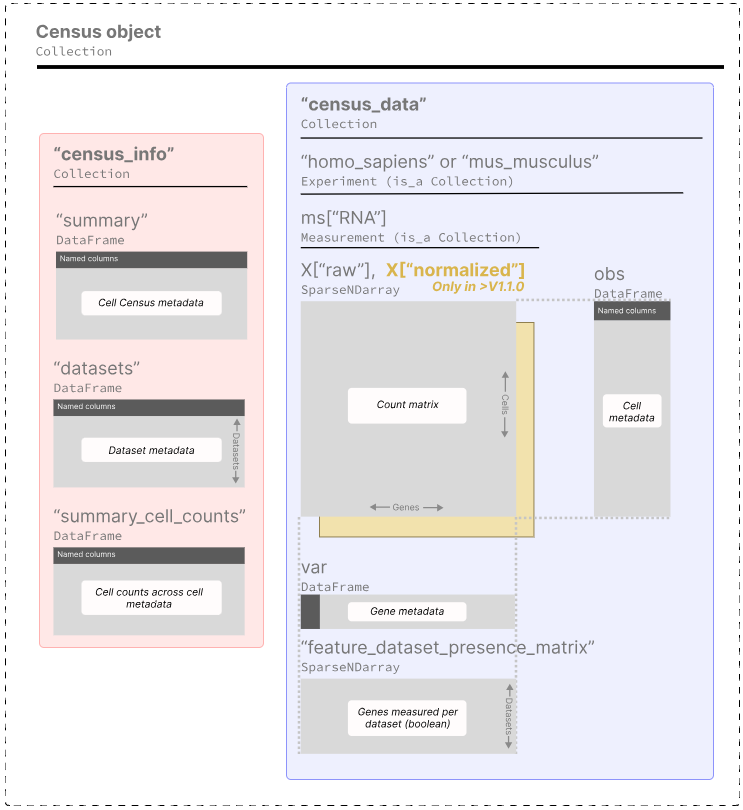

In [35]:
#open the census database
census = cellxgene_census.open_soma()

The "stable" release is currently 2023-07-25. Specify 'census_version="2023-07-25"' in future calls to open_soma() to ensure data consistency.


In [36]:
#fetch human RNA experiments
human = census["census_data"]["homo_sapiens"]
human_rna = human.ms["RNA"]

In [37]:
#fetch datasets in census
datasets_df = census["census_info"]["datasets"].read().concat().to_pandas()

datasets_df

,soma_joinid,collection_id,collection_name,collection_doi,dataset_id,dataset_title,dataset_h5ad_path,dataset_total_cell_count
0,0,e2c257e7-6f79-487c-b81c-39451cd4ab3c,Spatial multiomics map of trophoblast developm...,10.1038/s41586-023-05869-0,f171db61-e57e-4535-a06a-35d8b6ef8f2b,donor_p13_trophoblasts,f171db61-e57e-4535-a06a-35d8b6ef8f2b.h5ad,31497
1,1,e2c257e7-6f79-487c-b81c-39451cd4ab3c,Spatial multiomics map of trophoblast developm...,10.1038/s41586-023-05869-0,ecf2e08e-2032-4a9e-b466-b65b395f4a02,All donors trophoblasts,ecf2e08e-2032-4a9e-b466-b65b395f4a02.h5ad,67070
2,2,e2c257e7-6f79-487c-b81c-39451cd4ab3c,Spatial multiomics map of trophoblast developm...,10.1038/s41586-023-05869-0,74cff64f-9da9-4b2a-9b3b-8a04a1598040,All donors all cell states (in vivo),74cff64f-9da9-4b2a-9b3b-8a04a1598040.h5ad,286326
3,3,f7cecffa-00b4-4560-a29a-8ad626b8ee08,Mapping single-cell transcriptomes in the intr...,10.1016/j.ccell.2022.11.001,5af90777-6760-4003-9dba-8f945fec6fdf,Single-cell transcriptomic datasets of Renal c...,5af90777-6760-4003-9dba-8f945fec6fdf.h5ad,270855
4,4,3f50314f-bdc9-40c6-8e4a-b0901ebfbe4c,Single-cell sequencing links multiregional imm...,10.1016/j.ccell.2021.03.007,bd65a70f-b274-4133-b9dd-0d1431b6af34,Single-cell sequencing links multiregional imm...,bd65a70f-b274-4133-b9dd-0d1431b6af34.h5ad,167283
...,...,...,...,...,...,...,...,...
588,588,180bff9c-c8a5-4539-b13b-ddbc00d643e6,Molecular characterization of selectively vuln...,10.1038/s41593-020-00764-7,f9ad5649-f372-43e1-a3a8-423383e5a8a2,Molecular characterization of selectively vuln...,f9ad5649-f372-43e1-a3a8-423383e5a8a2.h5ad,8168
589,589,a72afd53-ab92-4511-88da-252fb0e26b9a,Single-cell atlas of peripheral immune respons...,10.1038/s41591-020-0944-y,456e8b9b-f872-488b-871d-94534090a865,Single-cell atlas of peripheral immune respons...,456e8b9b-f872-488b-871d-94534090a865.h5ad,44721
590,590,38833785-fac5-48fd-944a-0f62a4c23ed1,Construction of a human cell landscape at sing...,10.1038/s41586-020-2157-4,2adb1f8a-a6b1-4909-8ee8-484814e2d4bf,Construction of a human cell landscape at sing...,2adb1f8a-a6b1-4909-8ee8-484814e2d4bf.h5ad,598266
591,591,5d445965-6f1a-4b68-ba3a-b8f765155d3a,A molecular cell atlas of the human lung from ...,10.1038/s41586-020-2922-4,e04daea4-4412-45b5-989e-76a9be070a89,"Krasnow Lab Human Lung Cell Atlas, Smart-seq2",e04daea4-4412-45b5-989e-76a9be070a89.h5ad,9409


In [42]:
#search for Tabula Sapiens Dataset
datasets_df[datasets_df['collection_name'] == 'Tabula Sapiens'].sort_values(by = 'dataset_total_cell_count', 
                                                                                    ascending = True)

,soma_joinid,collection_id,collection_name,collection_doi,dataset_id,dataset_title,dataset_h5ad_path,dataset_total_cell_count
18,18,e5f58829-1a66-40b5-a624-9046778e74f5,Tabula Sapiens,10.1126/science.abl4896,6d41668c-168c-4500-b06a-4674ccf3e19d,Tabula Sapiens - Liver,6d41668c-168c-4500-b06a-4674ccf3e19d.h5ad,5007
17,17,e5f58829-1a66-40b5-a624-9046778e74f5,Tabula Sapiens,10.1126/science.abl4896,6ec405bb-4727-4c6d-ab4e-01fe489af7ea,Tabula Sapiens - Uterus,6ec405bb-4727-4c6d-ab4e-01fe489af7ea.h5ad,7124
28,28,e5f58829-1a66-40b5-a624-9046778e74f5,Tabula Sapiens,10.1126/science.abl4896,0041b9c3-6a49-4bf7-8514-9bc7190067a7,Tabula Sapiens - Skin,0041b9c3-6a49-4bf7-8514-9bc7190067a7.h5ad,9424
9,9,e5f58829-1a66-40b5-a624-9046778e74f5,Tabula Sapiens,10.1126/science.abl4896,d8732da6-8d1d-42d9-b625-f2416c30054b,Tabula Sapiens - Trachea,d8732da6-8d1d-42d9-b625-f2416c30054b.h5ad,9522
23,23,e5f58829-1a66-40b5-a624-9046778e74f5,Tabula Sapiens,10.1126/science.abl4896,2423ce2c-3149-4cca-a2ff-cf682ea29b5f,Tabula Sapiens - Kidney,2423ce2c-3149-4cca-a2ff-cf682ea29b5f.h5ad,9641
14,14,e5f58829-1a66-40b5-a624-9046778e74f5,Tabula Sapiens,10.1126/science.abl4896,a0754256-f44b-4c4a-962c-a552e47d3fdc,Tabula Sapiens - Eye,a0754256-f44b-4c4a-962c-a552e47d3fdc.h5ad,10650
22,22,e5f58829-1a66-40b5-a624-9046778e74f5,Tabula Sapiens,10.1126/science.abl4896,2ba40233-8576-4dec-a5f1-2adfa115e2dc,Tabula Sapiens - Mammary,2ba40233-8576-4dec-a5f1-2adfa115e2dc.h5ad,11375
7,7,e5f58829-1a66-40b5-a624-9046778e74f5,Tabula Sapiens,10.1126/science.abl4896,e6a11140-2545-46bc-929e-da243eed2cae,Tabula Sapiens - Heart,e6a11140-2545-46bc-929e-da243eed2cae.h5ad,11505
21,21,e5f58829-1a66-40b5-a624-9046778e74f5,Tabula Sapiens,10.1126/science.abl4896,4f1555bc-4664-46c3-a606-78d34dd10d92,Tabula Sapiens - Bone_Marrow,4f1555bc-4664-46c3-a606-78d34dd10d92.h5ad,12297
12,12,e5f58829-1a66-40b5-a624-9046778e74f5,Tabula Sapiens,10.1126/science.abl4896,a357414d-2042-4eb5-95f0-c58604a18bdd,Tabula Sapiens - Small_Intestine,a357414d-2042-4eb5-95f0-c58604a18bdd.h5ad,12467


In [ ]:
#download Tabula Sapiens Atlas for all cells
cellxgene_census.download_source_h5ad(dataset_id = '53d208b0-2cfd-4366-9866-c3c6114081bc', 
                                              to_path = '/home/jupyter/tabula_sapiens_all_cells.h5ad')

In [30]:
#read in Tabula Sapiens Atlas for all cells
tabula = sc.read_h5ad('tabula_sapiens_all_cells.h5ad')

tabula

AnnData object with n_obs × n_vars = 483152 × 58604
    obs: 'tissue_in_publication', 'assay_ontology_term_id', 'donor_id', 'anatomical_information', 'n_counts_UMIs', 'n_genes', 'cell_ontology_class', 'free_annotation', 'manually_annotated', 'compartment', 'sex_ontology_term_id', 'disease_ontology_term_id', 'is_primary_data', 'organism_ontology_term_id', 'suspension_type', 'cell_type_ontology_term_id', 'tissue_ontology_term_id', 'development_stage_ontology_term_id', 'self_reported_ethnicity_ontology_term_id', 'cell_type', 'assay', 'disease', 'organism', 'sex', 'tissue', 'self_reported_ethnicity', 'development_stage'
    var: 'feature_type', 'highly_variable', 'means', 'dispersions', 'dispersions_norm', 'mean', 'std', 'feature_is_filtered', 'feature_name', 'feature_reference', 'feature_biotype'
    uns: '_scvi', '_training_mode', 'dendrogram_cell_type_tissue', 'dendrogram_computational_compartment_assignment', 'dendrogram_consensus_prediction', 'dendrogram_tissue_cell_type', 'donor_id_c

The Tabula Sapiens - All Cells dataset is stored in anndata format which is equipped to deal with the storage and annotation of large biological datasets. The schema for the anndata object is shown below (image taken from [scanpy](https://scanpy.readthedocs.io/en/stable/usage-principles.html)).

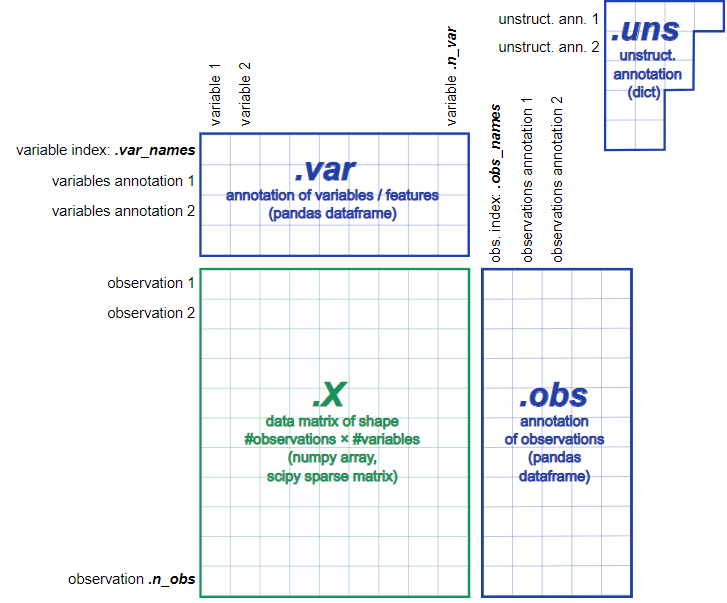

Herethe observations of the data points (metadata) are found in the **.obs** dataframe, the annotations of the features (genes) are found in the **.var** and the actual data itself (counts) is stored in the **.X** sparse matrix.

I wish to investigate the metadata stored in the Tabula Sapiens atlas and the features which have been measured so I will call these dataframes to visualise their contents.

# 2. Querying data 
## 2.1 Annotated observations for each cell (.obs)

In [4]:
#look at metadata observations
tabula.obs

,tissue_in_publication,assay_ontology_term_id,donor_id,anatomical_information,n_counts_UMIs,n_genes,cell_ontology_class,free_annotation,manually_annotated,compartment,...,development_stage_ontology_term_id,self_reported_ethnicity_ontology_term_id,cell_type,assay,disease,organism,sex,tissue,self_reported_ethnicity,development_stage
AAACCCACACTCCTGT_TSP6_Liver_NA_10X_1_1,Liver,EFO:0009922,TSP6,nan,7633.0,2259,macrophage,Monocyte/Macrophage,True,immune,...,HsapDv:0000161,HANCESTRO:0005,macrophage,10x 3' v3,normal,Homo sapiens,male,liver,European,67-year-old human stage
AAACGAAGTACCAGAG_TSP6_Liver_NA_10X_1_1,Liver,EFO:0009922,TSP6,nan,2858.0,1152,monocyte,Monocyte,True,immune,...,HsapDv:0000161,HANCESTRO:0005,monocyte,10x 3' v3,normal,Homo sapiens,male,liver,European,67-year-old human stage
AAACGCTCAACGGCTC_TSP6_Liver_NA_10X_1_1,Liver,EFO:0009922,TSP6,nan,7787.0,2983,endothelial cell of hepatic sinusoid,Endothelial,True,endothelial,...,HsapDv:0000161,HANCESTRO:0005,endothelial cell of hepatic sinusoid,10x 3' v3,normal,Homo sapiens,male,liver,European,67-year-old human stage
AAAGAACAGCCTCTTC_TSP6_Liver_NA_10X_1_1,Liver,EFO:0009922,TSP6,nan,10395.0,2598,macrophage,Monocyte/Macrophage,True,immune,...,HsapDv:0000161,HANCESTRO:0005,macrophage,10x 3' v3,normal,Homo sapiens,male,liver,European,67-year-old human stage
AAAGAACGTAGCACAG_TSP6_Liver_NA_10X_1_1,Liver,EFO:0009922,TSP6,nan,6610.0,2125,liver dendritic cell,Dendritic cell,True,immune,...,HsapDv:0000161,HANCESTRO:0005,liver dendritic cell,10x 3' v3,normal,Homo sapiens,male,liver,European,67-year-old human stage
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
TSP2_Vasculature_aorta_SS2_B114577_B133059_Endothelial_P4_S364,Vasculature,EFO:0008931,TSP2,aorta,13205.0,579,endothelial cell,endothelial cell,True,endothelial,...,HsapDv:0000155,HANCESTRO:0016,endothelial cell,Smart-seq2,normal,Homo sapiens,female,aorta,African American or Afro-Caribbean,61-year-old human stage
TSP2_Vasculature_aorta_SS2_B114577_B133059_Endothelial_P5_S365,Vasculature,EFO:0008931,TSP2,aorta,9565.0,529,endothelial cell,endothelial cell,True,endothelial,...,HsapDv:0000155,HANCESTRO:0016,endothelial cell,Smart-seq2,normal,Homo sapiens,female,aorta,African American or Afro-Caribbean,61-year-old human stage
TSP2_Vasculature_aorta_SS2_B114577_B133059_Endothelial_P7_S367,Vasculature,EFO:0008931,TSP2,aorta,195639.0,2753,endothelial cell,endothelial cell,True,endothelial,...,HsapDv:0000155,HANCESTRO:0016,endothelial cell,Smart-seq2,normal,Homo sapiens,female,aorta,African American or Afro-Caribbean,61-year-old human stage
TSP2_Vasculature_aorta_SS2_B114577_B133059_Endothelial_P8_S368,Vasculature,EFO:0008931,TSP2,aorta,37260.0,984,endothelial cell,endothelial cell,True,endothelial,...,HsapDv:0000155,HANCESTRO:0016,endothelial cell,Smart-seq2,normal,Homo sapiens,female,aorta,African American or Afro-Caribbean,61-year-old human stage


This confirms the presence of 483,152 cells as each row is an individual cell. Information on the donor id, the cell type, the tissue the cell derives from and which assay was used to obtain the data, to name a few, can be found here. I want to capture the number of unique tissues that the cells were sampled from and how many unique cell types have been annotated from this metadata.

In [44]:
tabula.obs['tissue_in_publication']

AAACCCACACTCCTGT_TSP6_Liver_NA_10X_1_1                                  Liver
AAACGAAGTACCAGAG_TSP6_Liver_NA_10X_1_1                                  Liver
AAACGCTCAACGGCTC_TSP6_Liver_NA_10X_1_1                                  Liver
AAAGAACAGCCTCTTC_TSP6_Liver_NA_10X_1_1                                  Liver
AAAGAACGTAGCACAG_TSP6_Liver_NA_10X_1_1                                  Liver
                                                                     ...     
TSP2_Vasculature_aorta_SS2_B114577_B133059_Endothelial_P4_S364    Vasculature
TSP2_Vasculature_aorta_SS2_B114577_B133059_Endothelial_P5_S365    Vasculature
TSP2_Vasculature_aorta_SS2_B114577_B133059_Endothelial_P7_S367    Vasculature
TSP2_Vasculature_aorta_SS2_B114577_B133059_Endothelial_P8_S368    Vasculature
TSP2_Vasculature_aorta_SS2_B114577_B133059_Endothelial_P9_S369    Vasculature
Name: tissue_in_publication, Length: 483152, dtype: category
Categories (24, object): ['Bladder', 'Blood', 'Bone_Marrow', 'Eye', ..., 'Tongue'

In [46]:
tabula.obs['tissue']

AAACCCACACTCCTGT_TSP6_Liver_NA_10X_1_1                            liver
AAACGAAGTACCAGAG_TSP6_Liver_NA_10X_1_1                            liver
AAACGCTCAACGGCTC_TSP6_Liver_NA_10X_1_1                            liver
AAAGAACAGCCTCTTC_TSP6_Liver_NA_10X_1_1                            liver
AAAGAACGTAGCACAG_TSP6_Liver_NA_10X_1_1                            liver
                                                                  ...  
TSP2_Vasculature_aorta_SS2_B114577_B133059_Endothelial_P4_S364    aorta
TSP2_Vasculature_aorta_SS2_B114577_B133059_Endothelial_P5_S365    aorta
TSP2_Vasculature_aorta_SS2_B114577_B133059_Endothelial_P7_S367    aorta
TSP2_Vasculature_aorta_SS2_B114577_B133059_Endothelial_P8_S368    aorta
TSP2_Vasculature_aorta_SS2_B114577_B133059_Endothelial_P9_S369    aorta
Name: tissue, Length: 483152, dtype: category
Categories (45, object): ['endocrine pancreas', 'exocrine pancreas', 'lymph node', 'large intestine', ..., 'muscle of pelvic diaphragm', 'anterior part of tongue'

For the tissue annotations there are two columns: tissue in publication and tissue. The former appears to be the tissues annotated in the paper from which the data is dervied (24 tissues) and the latter is a more in-depth description of the tissue of origin (45 tissues).

In [15]:
tabula.obs['cell_type']

AAACCCACACTCCTGT_TSP6_Liver_NA_10X_1_1                                                      macrophage
AAACGAAGTACCAGAG_TSP6_Liver_NA_10X_1_1                                                        monocyte
AAACGCTCAACGGCTC_TSP6_Liver_NA_10X_1_1                            endothelial cell of hepatic sinusoid
AAAGAACAGCCTCTTC_TSP6_Liver_NA_10X_1_1                                                      macrophage
AAAGAACGTAGCACAG_TSP6_Liver_NA_10X_1_1                                            liver dendritic cell
                                                                                  ...                 
TSP2_Vasculature_aorta_SS2_B114577_B133059_Endothelial_P4_S364                        endothelial cell
TSP2_Vasculature_aorta_SS2_B114577_B133059_Endothelial_P5_S365                        endothelial cell
TSP2_Vasculature_aorta_SS2_B114577_B133059_Endothelial_P7_S367                        endothelial cell
TSP2_Vasculature_aorta_SS2_B114577_B133059_Endothelial_P8_S368           

In [49]:
tabula.obs['cell_ontology_class']

AAACCCACACTCCTGT_TSP6_Liver_NA_10X_1_1                                                      macrophage
AAACGAAGTACCAGAG_TSP6_Liver_NA_10X_1_1                                                        monocyte
AAACGCTCAACGGCTC_TSP6_Liver_NA_10X_1_1                            endothelial cell of hepatic sinusoid
AAAGAACAGCCTCTTC_TSP6_Liver_NA_10X_1_1                                                      macrophage
AAAGAACGTAGCACAG_TSP6_Liver_NA_10X_1_1                                            liver dendritic cell
                                                                                  ...                 
TSP2_Vasculature_aorta_SS2_B114577_B133059_Endothelial_P4_S364                        endothelial cell
TSP2_Vasculature_aorta_SS2_B114577_B133059_Endothelial_P5_S365                        endothelial cell
TSP2_Vasculature_aorta_SS2_B114577_B133059_Endothelial_P7_S367                        endothelial cell
TSP2_Vasculature_aorta_SS2_B114577_B133059_Endothelial_P8_S368           

There are 160 different 'cell types' annotated but there are 177 different 'cell ontology class'. The former are annotations by single-cell experts and the latter are regularised annotations of the cell type so it would be best to use the standardised annotations.

It would be interesting to see the number of cells collected from each tissue to understand the distribution of cells across tissues in the dataset. Here, I carry this out on both `tissues_in_publication` and `tissue` columns.

In [40]:
tabula.obs.groupby('tissue_in_publication').cell_type.count()

/tmp/ipykernel_8246/3096505373.py:1: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  tabula.obs.groupby('tissue_in_publication').cell_type.count()


tissue_in_publication
Bladder            24583
Blood              50115
Bone_Marrow        12297
Eye                10650
Fat                20263
Heart              11505
Kidney              9641
Large_Intestine    13680
Liver               5007
Lung               35682
Lymph_Node         53275
Mammary            11375
Muscle             30746
Pancreas           13497
Prostate           16375
Salivary_Gland     27199
Skin                9424
Small_Intestine    12467
Spleen             34004
Thymus             33664
Tongue             15020
Trachea             9522
Uterus              7124
Vasculature        16037
Name: cell_type, dtype: int64

In [41]:
tabula.obs.groupby('tissue').cell_type.count()

/tmp/ipykernel_8246/1797432938.py:1: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  tabula.obs.groupby('tissue').cell_type.count()


tissue
endocrine pancreas              1520
exocrine pancreas              11977
lymph node                     44592
large intestine                13680
blood                          50115
aorta                           8384
cornea                          3505
eye                             2707
uterus                           286
adipose tissue                 10371
endometrium                     3813
myometrium                      3025
skin of abdomen                 2007
inguinal lymph node             8683
coronary artery                 4867
tongue                           186
sublingual gland                6196
sclera                          1431
conjunctiva                     2084
lacrimal gland                   248
parotid gland                  21003
skin of chest                   2398
mammary gland                  11375
lung                           35682
vasculature                     2786
cardiac atrium                  8279
cardiac ventricle              

## 2.2 Features across dataset and associated metrics

In [7]:
#look at data entries for genes
tabula.var

,feature_type,highly_variable,means,dispersions,dispersions_norm,mean,std,feature_is_filtered,feature_name,feature_reference,feature_biotype
ensemblid,,,,,,,,,,,
ENSG00000223972,Gene Expression,False,6.398244e-05,0.835044,-0.573947,0.000039,0.005574,False,DDX11L1,NCBITaxon:9606,gene
ENSG00000227232,Gene Expression,False,2.274395e-03,2.442280,0.533203,0.001080,0.031731,False,WASH7P,NCBITaxon:9606,gene
ENSG00000278267,Gene Expression,False,6.175251e-05,1.295335,-0.256874,0.000033,0.005634,False,MIR6859-1,NCBITaxon:9606,gene
ENSG00000243485,Gene Expression,False,1.372886e-04,2.656352,0.680668,0.000048,0.008041,False,MIR1302-2HG,NCBITaxon:9606,gene
ENSG00000284332,Gene Expression,False,1.000000e-12,NaN,0.000000,0.000000,1.000000,False,MIR1302-2,NCBITaxon:9606,gene
...,...,...,...,...,...,...,...,...,...,...,...
ENSG00000198695,Gene Expression,False,9.634841e-01,2.466404,0.154140,0.590065,0.741395,False,MT-ND6,NCBITaxon:9606,gene
ENSG00000210194,Gene Expression,False,1.600667e-01,1.603787,-0.044396,0.083929,0.301820,False,MT-TE,NCBITaxon:9606,gene
ENSG00000198727,Gene Expression,False,4.367693e+00,4.765751,-0.499747,3.874830,1.104192,False,MT-CYB,NCBITaxon:9606,gene


This table shows each individual gene measured in the cells (58,604 genes) and its mean expression across all the cells. The `ensemblid` for these genes is a standardised way to identify them but the actual gene name is `feature_name`.

## 2.3 Expression count data

In [50]:
tabula.X

<483152x58604 sparse matrix of type '<class 'numpy.float32'>'
	with 1270410953 stored elements in Compressed Sparse Row format>

The count data is stored in a sparse matrix which is a compressed datatype that only stores the index and value of non-zero entries. The **.X** sparse matrix contains log1p normalised and scaled decontX corrected counts for each gene in each cell and I will be using these counts for downstream investigation.

In [51]:
print(tabula.X)

  (0, 38)	2.3135314
  (0, 137)	2.017924
  (0, 148)	1.7682451
  (0, 197)	2.9146569
  (0, 229)	1.7524959
  (0, 256)	1.6055938
  (0, 266)	1.9191335
  (0, 273)	1.1627396
  (0, 297)	0.94154125
  (0, 332)	2.2555065
  (0, 350)	2.5699217
  (0, 364)	3.0685349
  (0, 366)	1.6374199
  (0, 386)	4.1950088
  (0, 416)	3.1584241
  (0, 420)	2.244354
  (0, 423)	1.790217
  (0, 477)	2.259219
  (0, 492)	2.2818408
  (0, 518)	1.5732617
  (0, 541)	1.986201
  (0, 581)	3.7468507
  (0, 612)	2.1255298
  (0, 623)	1.2339125
  (0, 625)	2.1744208
  :	:
  (483151, 57606)	2.9305413
  (483151, 57631)	0.0
  (483151, 57650)	0.0
  (483151, 57841)	0.0
  (483151, 57850)	0.7359118
  (483151, 57916)	0.655251
  (483151, 57934)	5.5935717
  (483151, 57943)	1.887764
  (483151, 57971)	0.2242891
  (483151, 58010)	0.35077646
  (483151, 58021)	0.9401592
  (483151, 58024)	1.9130006
  (483151, 58568)	2.6418934
  (483151, 58570)	6.581609
  (483151, 58572)	1.0534589
  (483151, 58576)	3.2490613
  (483151, 58582)	3.2477758
  (483151, 58585)	

# 3. Normalised and scaled count data

In [97]:
tabula_counts = pd.DataFrame.sparse.from_spmatrix(tabula.X)

In [98]:
#add gene names
gene_names = tabula.var['feature_name'].values.to_list()

tabula_counts = tabula_counts.set_axis(gene_names, axis = 1)

/tmp/ipykernel_1665/2122468128.py:2: FutureWarning: Categorical.to_list is deprecated and will be removed in a future version. Use obj.tolist() instead
  gene_names = tabula.var['feature_name'].values.to_list()


In [99]:
#add cell type
all_cell_type = tabula.obs['cell_ontology_class'].values.to_list()

tabula_counts.insert(0, 'cell_type', all_cell_type)

/tmp/ipykernel_1665/2057349549.py:2: FutureWarning: Categorical.to_list is deprecated and will be removed in a future version. Use obj.tolist() instead
  all_cell_type = tabula.obs['cell_type'].values.to_list()


In [100]:
tabula_counts

,cell_type,DDX11L1,WASH7P,MIR6859-1,MIR1302-2HG,MIR1302-2,FAM138A,OR4G4P,OR4G11P,OR4F5,...,MT-ND4,MT-TH,MT-TS2,MT-TL2,MT-ND5,MT-ND6,MT-TE,MT-CYB,MT-TT,MT-TP
0,macrophage,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,4.514050,0.0,0.0,0.0,3.066113,1.735281,0.0,4.651200,0.0,0.000000
1,monocyte,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,4.493524,0.0,0.0,0.0,3.011087,0.000000,0.0,4.890568,0.0,0.000000
2,endothelial cell of hepatic sinusoid,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,4.611789,0.0,0.0,0.0,3.832069,1.114132,0.0,4.693941,0.0,0.000000
3,macrophage,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,4.344065,0.0,0.0,0.0,2.975372,0.000000,0.0,4.572667,0.0,0.000000
4,liver dendritic cell,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,4.443695,0.0,0.0,0.0,3.143889,0.000000,0.0,4.533354,0.0,0.000000
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
483147,endothelial cell,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,3.455786,0.0,0.0,0.0,2.986555,0.760420,0.0,2.158757,0.0,0.000000
483148,endothelial cell,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,4.292184,0.0,0.0,0.0,3.560022,2.219024,0.0,3.486868,0.0,0.000000
483149,endothelial cell,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,3.031555,0.0,0.0,0.0,4.286012,2.549905,0.0,3.976863,0.0,5.355007
483150,endothelial cell,0.0,10.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,2.405994,0.0,0.0,0.0,4.814424,4.026218,0.0,3.945915,0.0,0.000000


The dataframe above is a cell x gene matrix where the values represent the expression of each gene in each individual cell which has been annoated by it's cell type. This dataset is huge as it contains information on 58,605 genes in 483,152 cells. Therefore, I can not continue my analysis for all cells in pandas. From here, I will choose a smaller subset of cells to establish an analysis pipeline which can then be expanded for all cells.

# Liver

# 1. Generate data subset
## 1.1 Download data subset

The liver dataset has the smallest number of cells (5007) within the Tabula Sapiens atlas so we'll subset these out and start analysis here first.

In [29]:
cellxgene_census.download_source_h5ad(dataset_id = '6d41668c-168c-4500-b06a-4674ccf3e19d', 
                                              to_path = '/home/jupyter/tabula_sapiens_liver.h5ad')

In [2]:
liver = sc.read_h5ad('tabula_sapiens_liver.h5ad')

In [33]:
liver

AnnData object with n_obs × n_vars = 5007 × 58604
    obs: 'assay_ontology_term_id', 'donor_id', 'anatomical_information', 'n_counts_UMIs', 'n_genes', 'cell_ontology_class', 'free_annotation', 'manually_annotated', 'compartment', 'sex_ontology_term_id', 'disease_ontology_term_id', 'is_primary_data', 'organism_ontology_term_id', 'suspension_type', 'cell_type_ontology_term_id', 'tissue_ontology_term_id', 'development_stage_ontology_term_id', 'self_reported_ethnicity_ontology_term_id', 'cell_type', 'assay', 'disease', 'organism', 'sex', 'tissue', 'self_reported_ethnicity', 'development_stage'
    var: 'feature_type', 'highly_variable', 'means', 'dispersions', 'dispersions_norm', 'mean', 'std', 'ensembl_version', 'feature_is_filtered', 'feature_name', 'feature_reference', 'feature_biotype'
    uns: '_scvi', '_training_mode', 'assay_colors', 'cell_ontology_class_colors', 'dendrogram_cell_type_tissue', 'dendrogram_computational_compartment_assignment', 'dendrogram_consensus_prediction', 'den

# 2. Querying Data
## 2.1 Liver Metadata

In [42]:
liver.obs

,assay_ontology_term_id,donor_id,anatomical_information,n_counts_UMIs,n_genes,cell_ontology_class,free_annotation,manually_annotated,compartment,sex_ontology_term_id,...,development_stage_ontology_term_id,self_reported_ethnicity_ontology_term_id,cell_type,assay,disease,organism,sex,tissue,self_reported_ethnicity,development_stage
cell_id,,,,,,,,,,,,,,,,,,,,,
AAACCCACACTCCTGT_TSP6_Liver_NA_10X_1_1,EFO:0009922,TSP6,nan,7633.0,2259,macrophage,Monocyte/Macrophage,True,immune,PATO:0000384,...,HsapDv:0000161,HANCESTRO:0005,macrophage,10x 3' v3,normal,Homo sapiens,male,liver,European,67-year-old human stage
AAACGAAGTACCAGAG_TSP6_Liver_NA_10X_1_1,EFO:0009922,TSP6,nan,2858.0,1152,monocyte,Monocyte,True,immune,PATO:0000384,...,HsapDv:0000161,HANCESTRO:0005,monocyte,10x 3' v3,normal,Homo sapiens,male,liver,European,67-year-old human stage
AAACGCTCAACGGCTC_TSP6_Liver_NA_10X_1_1,EFO:0009922,TSP6,nan,7787.0,2983,endothelial cell of hepatic sinusoid,Endothelial,True,endothelial,PATO:0000384,...,HsapDv:0000161,HANCESTRO:0005,endothelial cell of hepatic sinusoid,10x 3' v3,normal,Homo sapiens,male,liver,European,67-year-old human stage
AAAGAACAGCCTCTTC_TSP6_Liver_NA_10X_1_1,EFO:0009922,TSP6,nan,10395.0,2598,macrophage,Monocyte/Macrophage,True,immune,PATO:0000384,...,HsapDv:0000161,HANCESTRO:0005,macrophage,10x 3' v3,normal,Homo sapiens,male,liver,European,67-year-old human stage
AAAGAACGTAGCACAG_TSP6_Liver_NA_10X_1_1,EFO:0009922,TSP6,nan,6610.0,2125,liver dendritic cell,Dendritic cell,True,immune,PATO:0000384,...,HsapDv:0000161,HANCESTRO:0005,liver dendritic cell,10x 3' v3,normal,Homo sapiens,male,liver,European,67-year-old human stage
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
TTTGATCCATCGGCCA_TSP14_Liver_NA_10X_2_1,EFO:0009922,TSP14,nan,32707.0,4815,hepatocyte,Hepatocyte,True,epithelial,PATO:0000384,...,HsapDv:0000153,HANCESTRO:0005,hepatocyte,10x 3' v3,normal,Homo sapiens,male,liver,European,59-year-old human stage
TTTGGAGTCAGTCTTT_TSP14_Liver_NA_10X_2_1,EFO:0009922,TSP14,nan,19864.0,3526,hepatocyte,Hepatocyte,True,epithelial,PATO:0000384,...,HsapDv:0000153,HANCESTRO:0005,hepatocyte,10x 3' v3,normal,Homo sapiens,male,liver,European,59-year-old human stage
TTTGGTTGTCACTCGG_TSP14_Liver_NA_10X_2_1,EFO:0009922,TSP14,nan,2550.0,1389,endothelial cell of hepatic sinusoid,Endothelial,True,endothelial,PATO:0000384,...,HsapDv:0000153,HANCESTRO:0005,endothelial cell of hepatic sinusoid,10x 3' v3,normal,Homo sapiens,male,liver,European,59-year-old human stage


## 2.2 Liver Feature Data

In [43]:
liver.var

,feature_type,highly_variable,means,dispersions,dispersions_norm,mean,std,ensembl_version,feature_is_filtered,feature_name,feature_reference,feature_biotype
ensemblid,,,,,,,,,,,,
ENSG00000223972,Gene Expression,False,6.398244e-05,0.835044,-0.573947,0.000039,0.005574,ENSG00000223972.5,False,DDX11L1,NCBITaxon:9606,gene
ENSG00000227232,Gene Expression,False,2.274395e-03,2.442280,0.533203,0.001080,0.031731,ENSG00000227232.5,False,WASH7P,NCBITaxon:9606,gene
ENSG00000278267,Gene Expression,False,6.175251e-05,1.295335,-0.256874,0.000033,0.005634,ENSG00000278267.1,False,MIR6859-1,NCBITaxon:9606,gene
ENSG00000243485,Gene Expression,False,1.372886e-04,2.656352,0.680668,0.000048,0.008041,ENSG00000243485.5,False,MIR1302-2HG,NCBITaxon:9606,gene
ENSG00000284332,Gene Expression,False,1.000000e-12,NaN,0.000000,0.000000,1.000000,ENSG00000284332.1,False,MIR1302-2,NCBITaxon:9606,gene
...,...,...,...,...,...,...,...,...,...,...,...,...
ENSG00000198695,Gene Expression,False,9.634841e-01,2.466404,0.154140,0.590065,0.741395,ENSG00000198695.2,False,MT-ND6,NCBITaxon:9606,gene
ENSG00000210194,Gene Expression,False,1.600667e-01,1.603787,-0.044396,0.083929,0.301820,ENSG00000210194.1,False,MT-TE,NCBITaxon:9606,gene
ENSG00000198727,Gene Expression,False,4.367693e+00,4.765751,-0.499747,3.874830,1.104192,ENSG00000198727.2,False,MT-CYB,NCBITaxon:9606,gene


# 3. Normalised feature count matrix with feature_name
## 3.1 Normalised feature counts in each cell from liver

In [49]:
#log1p normalised and scaled decontX corrected counts
print(liver.X)

  (0, 38)	2.3135314
  (0, 137)	2.017924
  (0, 148)	1.7682451
  (0, 197)	2.9146569
  (0, 229)	1.7524959
  (0, 256)	1.6055938
  (0, 266)	1.9191335
  (0, 273)	1.1627396
  (0, 297)	0.94154125
  (0, 332)	2.2555065
  (0, 350)	2.5699217
  (0, 364)	3.0685349
  (0, 366)	1.6374199
  (0, 386)	4.1950088
  (0, 416)	3.1584241
  (0, 420)	2.244354
  (0, 423)	1.790217
  (0, 477)	2.259219
  (0, 492)	2.2818408
  (0, 518)	1.5732617
  (0, 541)	1.986201
  (0, 581)	3.7468507
  (0, 612)	2.1255298
  (0, 623)	1.2339125
  (0, 625)	2.1744208
  :	:
  (5006, 57216)	10.0
  (5006, 57306)	3.2512813
  (5006, 57363)	1.8781296
  (5006, 57371)	1.8061343
  (5006, 57464)	10.0
  (5006, 57597)	6.4817824
  (5006, 57700)	10.0
  (5006, 58107)	6.480399
  (5006, 58241)	5.1344576
  (5006, 58332)	10.0
  (5006, 58348)	4.1966047
  (5006, 58351)	6.4616237
  (5006, 58568)	2.2135978
  (5006, 58570)	3.0771492
  (5006, 58572)	0.0
  (5006, 58576)	0.0
  (5006, 58582)	0.0
  (5006, 58585)	1.4261405
  (5006, 58588)	2.0721047
  (5006, 58589)	2.1

Compared to the whole cell dataset we see that the index only goes as far as 5006 since there are only 5007 cells in this sample. The sparse matrix format makes it hard to visualise and carry out analysis on the values therefore I first need to convert it into a pandas dataframe.

In [3]:
#convert sparse matrix into pandas dataframe for downstream analysis
liver_counts = pd.DataFrame.sparse.from_spmatrix(liver.X)

liver_counts

,0,1,2,3,4,5,6,7,8,9,...,58594,58595,58596,58597,58598,58599,58600,58601,58602,58603
0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,4.514050,0.000000,0.000000,0.0,3.066113,1.735281,0.000000,4.651200,0.0,0.000000
1,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,4.493524,0.000000,0.000000,0.0,3.011087,0.000000,0.000000,4.890568,0.0,0.000000
2,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,4.611789,0.000000,0.000000,0.0,3.832069,1.114132,0.000000,4.693941,0.0,0.000000
3,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,4.344065,0.000000,0.000000,0.0,2.975372,0.000000,0.000000,4.572667,0.0,0.000000
4,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,4.443695,0.000000,0.000000,0.0,3.143889,0.000000,0.000000,4.533354,0.0,0.000000
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
5002,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,4.577865,1.506503,0.792537,0.0,3.344307,1.543429,0.883882,4.122873,0.0,2.078453
5003,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,4.099157,0.000000,1.211337,0.0,2.707354,0.939532,4.610079,3.635269,0.0,1.836136
5004,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,1.390459,0.000000,0.000000,0.0,0.000000,0.000000,0.000000,1.973971,0.0,0.000000
5005,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,1.335147,0.000000,0.000000,0.0,1.490789,0.000000,0.000000,2.239632,0.0,0.000000


Here the row index represents each individual cell in the liver dataset and the column index represents the genes measured. However, from this, I am unable to determine the gene expression for a specific gene in a particular cell therefore before any further analysis it would be best to label the axes with cell information and gene names.

In [4]:
#add gene names
gene_names = liver.var['feature_name'].values.to_list()

liver_counts = liver_counts.set_axis(gene_names, axis = 1)

/tmp/ipykernel_8246/3747516722.py:2: FutureWarning: Categorical.to_list is deprecated and will be removed in a future version. Use obj.tolist() instead
  gene_names = liver.var['feature_name'].values.to_list()


In [5]:
#add cell type
cell_type = liver.obs['cell_ontology_class'].values.to_list()

liver_counts.insert(0, 'cell_type', cell_type)

/tmp/ipykernel_8246/1667413443.py:2: FutureWarning: Categorical.to_list is deprecated and will be removed in a future version. Use obj.tolist() instead
  cell_type = liver.obs['cell_ontology_class'].values.to_list()


In [6]:
#add cell_id
cell_id = liver.obs.index.values
liver_counts.insert(0, 'cell_id', cell_id)

In [7]:
liver_counts

,cell_id,cell_type,DDX11L1,WASH7P,MIR6859-1,MIR1302-2HG,MIR1302-2,FAM138A,OR4G4P,OR4G11P,...,MT-ND4,MT-TH,MT-TS2,MT-TL2,MT-ND5,MT-ND6,MT-TE,MT-CYB,MT-TT,MT-TP
0,AAACCCACACTCCTGT_TSP6_Liver_NA_10X_1_1,macrophage,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,4.514050,0.000000,0.000000,0.0,3.066113,1.735281,0.000000,4.651200,0.0,0.000000
1,AAACGAAGTACCAGAG_TSP6_Liver_NA_10X_1_1,monocyte,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,4.493524,0.000000,0.000000,0.0,3.011087,0.000000,0.000000,4.890568,0.0,0.000000
2,AAACGCTCAACGGCTC_TSP6_Liver_NA_10X_1_1,endothelial cell of hepatic sinusoid,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,4.611789,0.000000,0.000000,0.0,3.832069,1.114132,0.000000,4.693941,0.0,0.000000
3,AAAGAACAGCCTCTTC_TSP6_Liver_NA_10X_1_1,macrophage,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,4.344065,0.000000,0.000000,0.0,2.975372,0.000000,0.000000,4.572667,0.0,0.000000
4,AAAGAACGTAGCACAG_TSP6_Liver_NA_10X_1_1,liver dendritic cell,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,4.443695,0.000000,0.000000,0.0,3.143889,0.000000,0.000000,4.533354,0.0,0.000000
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
5002,TTTGATCCATCGGCCA_TSP14_Liver_NA_10X_2_1,hepatocyte,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,4.577865,1.506503,0.792537,0.0,3.344307,1.543429,0.883882,4.122873,0.0,2.078453
5003,TTTGGAGTCAGTCTTT_TSP14_Liver_NA_10X_2_1,hepatocyte,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,4.099157,0.000000,1.211337,0.0,2.707354,0.939532,4.610079,3.635269,0.0,1.836136
5004,TTTGGTTGTCACTCGG_TSP14_Liver_NA_10X_2_1,endothelial cell of hepatic sinusoid,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,1.390459,0.000000,0.000000,0.0,0.000000,0.000000,0.000000,1.973971,0.0,0.000000
5005,TTTGTTGAGGACTGGT_TSP14_Liver_NA_10X_2_1,nk cell,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,1.335147,0.000000,0.000000,0.0,1.490789,0.000000,0.000000,2.239632,0.0,0.000000


This is better as I can now see expression counts for the genes in a particular cell type.

## 3.2 Convert normalised feature count matrix from wide to long format

The `liver_counts` dataframe is useful for visualising the counts however it does make quantitative analysis very difficult since the expression values are spread out across multiple columns for each cell and spread across multiple rows for each gene. The dataframe requires restructuring so that all the expression values fall within the same column and similarly with cell id, cell type and feature name. This can be achieved by converting the dataframe from wide to long format.

In [7]:
#set columns that are to be pivoted to one column
cols = liver_counts.columns[2:]

#pivot dataframe so all gene columns become one column named expression
melted_liver_counts = pd.melt(liver_counts, id_vars = ['cell_id', 'cell_type'], 
                            value_vars = cols, 
                           var_name = 'feature_name', 
                           value_name = 'expression')

In [8]:
melted_liver_counts

,cell_id,cell_type,feature_name,expression
0,AAACCCACACTCCTGT_TSP6_Liver_NA_10X_1_1,macrophage,DDX11L1,0.000000
1,AAACGAAGTACCAGAG_TSP6_Liver_NA_10X_1_1,monocyte,DDX11L1,0.000000
2,AAACGCTCAACGGCTC_TSP6_Liver_NA_10X_1_1,endothelial cell of hepatic sinusoid,DDX11L1,0.000000
3,AAAGAACAGCCTCTTC_TSP6_Liver_NA_10X_1_1,macrophage,DDX11L1,0.000000
4,AAAGAACGTAGCACAG_TSP6_Liver_NA_10X_1_1,liver dendritic cell,DDX11L1,0.000000
...,...,...,...,...
293430223,TTTGATCCATCGGCCA_TSP14_Liver_NA_10X_2_1,hepatocyte,MT-TP,2.078453
293430224,TTTGGAGTCAGTCTTT_TSP14_Liver_NA_10X_2_1,hepatocyte,MT-TP,1.836136
293430225,TTTGGTTGTCACTCGG_TSP14_Liver_NA_10X_2_1,endothelial cell of hepatic sinusoid,MT-TP,0.000000
293430226,TTTGTTGAGGACTGGT_TSP14_Liver_NA_10X_2_1,nk cell,MT-TP,0.000000


Now, all the expressions fall in a single column and each entry is annotated using the `cell_id`, `cell_type` and `feature_name` columns.

## 3.3 Convert expression column from sparse to dense format

After failed attempts to calculate metrics on the expression column, the datatype of each column was investigated to shed a light on the problem.

In [55]:
melted_liver_counts.dtypes

cell_id                     object
cell_type                   object
feature_name                object
expression      Sparse[float32, 0]
dtype: object

Here, it is evident that whilst I may have converted the `liver.X` sparse matrix to a dataframe, it did not alter the values within the dataframe which remained as sparse. Therefore, to perform these summary statistics I changed the datatype of the expression column from sparse to dense which saves all the values as they appear including zeros.

In [8]:
melted_liver_counts.expression = melted_liver_counts.expression.values.to_dense()

In [57]:
melted_liver_counts.dtypes

cell_id          object
cell_type        object
feature_name     object
expression      float32
dtype: object

Now, the data in the column is stored as a float32 datatype which is usable for summary statistics.

# 4. Exponentiated feature count matrix with feature_names

## 4.1 Exponentiate counts in expression column

In [9]:
melted_liver_counts.expression = np.expm1(melted_liver_counts.expression)

melted_liver_counts

,cell_id,cell_type,feature_name,expression
0,AAACCCACACTCCTGT_TSP6_Liver_NA_10X_1_1,macrophage,DDX11L1,0.000000
1,AAACGAAGTACCAGAG_TSP6_Liver_NA_10X_1_1,monocyte,DDX11L1,0.000000
2,AAACGCTCAACGGCTC_TSP6_Liver_NA_10X_1_1,endothelial cell of hepatic sinusoid,DDX11L1,0.000000
3,AAAGAACAGCCTCTTC_TSP6_Liver_NA_10X_1_1,macrophage,DDX11L1,0.000000
4,AAAGAACGTAGCACAG_TSP6_Liver_NA_10X_1_1,liver dendritic cell,DDX11L1,0.000000
...,...,...,...,...
293430223,TTTGATCCATCGGCCA_TSP14_Liver_NA_10X_2_1,hepatocyte,MT-TP,6.992094
293430224,TTTGGAGTCAGTCTTT_TSP14_Liver_NA_10X_2_1,hepatocyte,MT-TP,5.272258
293430225,TTTGGTTGTCACTCGG_TSP14_Liver_NA_10X_2_1,endothelial cell of hepatic sinusoid,MT-TP,0.000000
293430226,TTTGTTGAGGACTGGT_TSP14_Liver_NA_10X_2_1,nk cell,MT-TP,0.000000


## 4.2 Calculate summary for exponentiated counts grouped by cell_type

In [21]:
melted_liver_counts.groupby(['cell_type', 'feature_name']).describe()

expression                                \
                                         count mean  std  min  25%  50%  75%   
cell_type   feature_name                                                       
T cell      5S_rRNA_ENSG00000276861      146.0  0.0  0.0  0.0  0.0  0.0  0.0   
            5S_rRNA_ENSG00000277411      146.0  0.0  0.0  0.0  0.0  0.0  0.0   
            5S_rRNA_ENSG00000277488      146.0  0.0  0.0  0.0  0.0  0.0  0.0   
            5S_rRNA_ENSG00000285609      146.0  0.0  0.0  0.0  0.0  0.0  0.0   
            5S_rRNA_ENSG00000285626      146.0  0.0  0.0  0.0  0.0  0.0  0.0   
...                                        ...  ...  ...  ...  ...  ...  ...   
plasma cell bP-2189O9.5                   34.0  0.0  0.0  0.0  0.0  0.0  0.0   
            hsa-mir-1253                  34.0  0.0  0.0  0.0  0.0  0.0  0.0   
            hsa-mir-423                   34.0  0.0  0.0  0.0  0.0  0.0  0.0   
            snoZ196                       34.0  0.0  0.0  0.0  0.0  0.0  0.0   
            yR211F11.2                    34.0  0.0  0.0  0.0  0.0  0.0  0.0   

                                          
                                     max  
cell_type   feature_name                  
T cell      5S_rRNA_ENSG00000276861  0.0  
            5S_rRNA_ENSG00000277411  0.0  
            5S_rRNA_ENSG00000277488  0.0  
            5S_rRNA_ENSG00000285609  0.0  
            5S_rRNA_ENSG00000285626  0.0  
...                                  ...  
plasma cell bP-2189O9.5              0.0  
            hsa-mir-1253             0.0  
            hsa-mir-423              0.0  
            snoZ196                  0.0  
            yR211F11.2               0.0  

[761852 rows x 8 columns]

## 4.3 Calculate median for exponentiated counts grouped by cell_type

In [10]:
median_exp_liver_counts = melted_liver_counts.groupby(['cell_type', 'feature_name']).median('expression')

median_exp_liver_counts

expression
cell_type        feature_name                       
endothelial cell 5S_rRNA_ENSG00000276861         0.0
                 5S_rRNA_ENSG00000277411         0.0
                 5S_rRNA_ENSG00000277488         0.0
                 5S_rRNA_ENSG00000285609         0.0
                 5S_rRNA_ENSG00000285626         0.0
...                                              ...
t cell           bP-2189O9.5                     0.0
                 hsa-mir-1253                    0.0
                 hsa-mir-423                     0.0
                 snoZ196                         0.0
                 yR211F11.2                      0.0

[761852 rows x 1 columns]

In [60]:
median_exp_liver_counts.to_parquet('liver/median_exp_liver_counts.parquet')

## 4.4 Create cell_type x gene median exp count

In [11]:
median_exp_liver_counts = median_exp_liver_counts.reset_index()

median_exp_liver_counts

,cell_type,feature_name,expression
0,endothelial cell,5S_rRNA_ENSG00000276861,0.0
1,endothelial cell,5S_rRNA_ENSG00000277411,0.0
2,endothelial cell,5S_rRNA_ENSG00000277488,0.0
3,endothelial cell,5S_rRNA_ENSG00000285609,0.0
4,endothelial cell,5S_rRNA_ENSG00000285626,0.0
...,...,...,...
761847,t cell,bP-2189O9.5,0.0
761848,t cell,hsa-mir-1253,0.0
761849,t cell,hsa-mir-423,0.0
761850,t cell,snoZ196,0.0


In [12]:
cell_typexgene_median = median_exp_liver_counts.pivot(index = 'cell_type', columns = 'feature_name', values = 'expression')

cell_typexgene_median

feature_name,5S_rRNA_ENSG00000276861,5S_rRNA_ENSG00000277411,5S_rRNA_ENSG00000277488,5S_rRNA_ENSG00000285609,5S_rRNA_ENSG00000285626,5S_rRNA_ENSG00000285674,5S_rRNA_ENSG00000285776,5S_rRNA_ENSG00000285912,5_8S_rRNA_ENSG00000275877,5_8S_rRNA_ENSG00000276871,...,bP-2168N6.3,bP-2171C21.2,bP-2171C21.3,bP-2171C21.5,bP-2189O9.2,bP-2189O9.5,hsa-mir-1253,hsa-mir-423,snoZ196,yR211F11.2
cell_type,,,,,,,,,,,,,,,,,,,,,
endothelial cell,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
endothelial cell of hepatic sinusoid,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
erythrocyte,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
fibroblast,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
hepatocyte,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
intrahepatic cholangiocyte,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
liver dendritic cell,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
macrophage,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
monocyte,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


In [27]:
cell_typexgene_median.to_parquet('liver/cell_typexgene_median.parquet')

# 5. Normalised feature count matrix with ensemblid
## 5.1 Normalised feature count matrix

In [15]:
#convert sparse matrix into pandas dataframe
liver_counts = pd.DataFrame.sparse.from_spmatrix(liver.X)

liver_counts

,0,1,2,3,4,5,6,7,8,9,...,58594,58595,58596,58597,58598,58599,58600,58601,58602,58603
0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,4.514050,0.000000,0.000000,0.0,3.066113,1.735281,0.000000,4.651200,0.0,0.000000
1,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,4.493524,0.000000,0.000000,0.0,3.011087,0.000000,0.000000,4.890568,0.0,0.000000
2,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,4.611789,0.000000,0.000000,0.0,3.832069,1.114132,0.000000,4.693941,0.0,0.000000
3,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,4.344065,0.000000,0.000000,0.0,2.975372,0.000000,0.000000,4.572667,0.0,0.000000
4,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,4.443695,0.000000,0.000000,0.0,3.143889,0.000000,0.000000,4.533354,0.0,0.000000
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
5002,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,4.577865,1.506503,0.792537,0.0,3.344307,1.543429,0.883882,4.122873,0.0,2.078453
5003,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,4.099157,0.000000,1.211337,0.0,2.707354,0.939532,4.610079,3.635269,0.0,1.836136
5004,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,1.390459,0.000000,0.000000,0.0,0.000000,0.000000,0.000000,1.973971,0.0,0.000000
5005,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,1.335147,0.000000,0.000000,0.0,1.490789,0.000000,0.000000,2.239632,0.0,0.000000


In [16]:
#add ensemblid
ensemblid = liver.var.index.values
liver_counts_ensemblid = liver_counts.set_axis(ensemblid, axis = 1)

#add cell_id and cell_type as columns
cell_id = liver.obs.index.values
cell_type = liver.obs['cell_ontology_class'].values.to_list()
liver_counts_ensemblid.insert(0, 'cell_id', cell_id)
liver_counts_ensemblid.insert(1, 'cell_type', cell_type)

/tmp/ipykernel_1438/1230489219.py:7: FutureWarning: Categorical.to_list is deprecated and will be removed in a future version. Use obj.tolist() instead
  cell_type = liver.obs['cell_ontology_class'].values.to_list()


In [30]:
liver_counts_ensemblid

,cell_id,cell_type,ENSG00000223972,ENSG00000227232,ENSG00000278267,ENSG00000243485,ENSG00000284332,ENSG00000237613,ENSG00000268020,ENSG00000240361,...,ENSG00000198886,ENSG00000210176,ENSG00000210184,ENSG00000210191,ENSG00000198786,ENSG00000198695,ENSG00000210194,ENSG00000198727,ENSG00000210195,ENSG00000210196
0,AAACCCACACTCCTGT_TSP6_Liver_NA_10X_1_1,macrophage,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,4.514050,0.000000,0.000000,0.0,3.066113,1.735281,0.000000,4.651200,0.0,0.000000
1,AAACGAAGTACCAGAG_TSP6_Liver_NA_10X_1_1,monocyte,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,4.493524,0.000000,0.000000,0.0,3.011087,0.000000,0.000000,4.890568,0.0,0.000000
2,AAACGCTCAACGGCTC_TSP6_Liver_NA_10X_1_1,endothelial cell of hepatic sinusoid,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,4.611789,0.000000,0.000000,0.0,3.832069,1.114132,0.000000,4.693941,0.0,0.000000
3,AAAGAACAGCCTCTTC_TSP6_Liver_NA_10X_1_1,macrophage,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,4.344065,0.000000,0.000000,0.0,2.975372,0.000000,0.000000,4.572667,0.0,0.000000
4,AAAGAACGTAGCACAG_TSP6_Liver_NA_10X_1_1,liver dendritic cell,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,4.443695,0.000000,0.000000,0.0,3.143889,0.000000,0.000000,4.533354,0.0,0.000000
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
5002,TTTGATCCATCGGCCA_TSP14_Liver_NA_10X_2_1,hepatocyte,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,4.577865,1.506503,0.792537,0.0,3.344307,1.543429,0.883882,4.122873,0.0,2.078453
5003,TTTGGAGTCAGTCTTT_TSP14_Liver_NA_10X_2_1,hepatocyte,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,4.099157,0.000000,1.211337,0.0,2.707354,0.939532,4.610079,3.635269,0.0,1.836136
5004,TTTGGTTGTCACTCGG_TSP14_Liver_NA_10X_2_1,endothelial cell of hepatic sinusoid,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,1.390459,0.000000,0.000000,0.0,0.000000,0.000000,0.000000,1.973971,0.0,0.000000
5005,TTTGTTGAGGACTGGT_TSP14_Liver_NA_10X_2_1,nk cell,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,1.335147,0.000000,0.000000,0.0,1.490789,0.000000,0.000000,2.239632,0.0,0.000000


## 5.2 Convert wide to long format

In [17]:
cols = liver_counts_ensemblid.columns[2:]

melted_liver_counts_ensemblid = pd.melt(liver_counts_ensemblid, id_vars = ['cell_id', 'cell_type'], 
                            value_vars = cols, 
                           var_name = 'ensemblid', 
                           value_name = 'expression')

melted_liver_counts_ensemblid

,cell_id,cell_type,ensemblid,expression
0,AAACCCACACTCCTGT_TSP6_Liver_NA_10X_1_1,macrophage,ENSG00000223972,0.000000
1,AAACGAAGTACCAGAG_TSP6_Liver_NA_10X_1_1,monocyte,ENSG00000223972,0.000000
2,AAACGCTCAACGGCTC_TSP6_Liver_NA_10X_1_1,endothelial cell of hepatic sinusoid,ENSG00000223972,0.000000
3,AAAGAACAGCCTCTTC_TSP6_Liver_NA_10X_1_1,macrophage,ENSG00000223972,0.000000
4,AAAGAACGTAGCACAG_TSP6_Liver_NA_10X_1_1,liver dendritic cell,ENSG00000223972,0.000000
...,...,...,...,...
293430223,TTTGATCCATCGGCCA_TSP14_Liver_NA_10X_2_1,hepatocyte,ENSG00000210196,2.078453
293430224,TTTGGAGTCAGTCTTT_TSP14_Liver_NA_10X_2_1,hepatocyte,ENSG00000210196,1.836136
293430225,TTTGGTTGTCACTCGG_TSP14_Liver_NA_10X_2_1,endothelial cell of hepatic sinusoid,ENSG00000210196,0.000000
293430226,TTTGTTGAGGACTGGT_TSP14_Liver_NA_10X_2_1,nk cell,ENSG00000210196,0.000000


## 5.3 Convert sparse expression column to dense

In [18]:
melted_liver_counts_ensemblid.expression = melted_liver_counts_ensemblid.expression.values.to_dense()

# 6. Exponentiate feature count matrix with ensemblid
## 6.1 Exponentiate expression column

In [19]:
melted_liver_counts_ensemblid.expression = np.expm1(melted_liver_counts_ensemblid.expression)

melted_liver_counts

,cell_id,cell_type,feature_name,expression
0,AAACCCACACTCCTGT_TSP6_Liver_NA_10X_1_1,macrophage,DDX11L1,0.000000
1,AAACGAAGTACCAGAG_TSP6_Liver_NA_10X_1_1,monocyte,DDX11L1,0.000000
2,AAACGCTCAACGGCTC_TSP6_Liver_NA_10X_1_1,endothelial cell of hepatic sinusoid,DDX11L1,0.000000
3,AAAGAACAGCCTCTTC_TSP6_Liver_NA_10X_1_1,macrophage,DDX11L1,0.000000
4,AAAGAACGTAGCACAG_TSP6_Liver_NA_10X_1_1,liver dendritic cell,DDX11L1,0.000000
...,...,...,...,...
293430223,TTTGATCCATCGGCCA_TSP14_Liver_NA_10X_2_1,hepatocyte,MT-TP,6.992094
293430224,TTTGGAGTCAGTCTTT_TSP14_Liver_NA_10X_2_1,hepatocyte,MT-TP,5.272258
293430225,TTTGGTTGTCACTCGG_TSP14_Liver_NA_10X_2_1,endothelial cell of hepatic sinusoid,MT-TP,0.000000
293430226,TTTGTTGAGGACTGGT_TSP14_Liver_NA_10X_2_1,nk cell,MT-TP,0.000000


## 6.2 Median exponentiated feature counts with ensemblid

In [20]:
median_ensembl_liver_counts = melted_liver_counts_ensemblid.groupby(['cell_type', 'ensemblid']).median('expression')

median_ensembl_liver_counts

expression
cell_type        ensemblid                  
endothelial cell ENSG00000000003         0.0
                 ENSG00000000005         0.0
                 ENSG00000000419         0.0
                 ENSG00000000457         0.0
                 ENSG00000000460         0.0
...                                      ...
t cell           ENSG00000286268         0.0
                 ENSG00000286269         0.0
                 ENSG00000286270         0.0
                 ENSG00000286271         0.0
                 ENSG00000286272         0.0

[761852 rows x 1 columns]

In [68]:
median_ensembl_liver_counts.to_parquet('liver/median_ensembl_exp_liver_counts.parquet')

## 6.3 Create cell_type x gene median exp count with ensemblid

In [21]:
median_ensembl_liver_counts = median_ensembl_liver_counts.reset_index()

median_ensembl_liver_counts

,cell_type,ensemblid,expression
0,endothelial cell,ENSG00000000003,0.0
1,endothelial cell,ENSG00000000005,0.0
2,endothelial cell,ENSG00000000419,0.0
3,endothelial cell,ENSG00000000457,0.0
4,endothelial cell,ENSG00000000460,0.0
...,...,...,...
761847,t cell,ENSG00000286268,0.0
761848,t cell,ENSG00000286269,0.0
761849,t cell,ENSG00000286270,0.0
761850,t cell,ENSG00000286271,0.0


In [22]:
cell_typexgene_median_ensemblid = median_ensembl_liver_counts.pivot(index = 'cell_type', columns = 'ensemblid', 
                                                                    values = 'expression')

cell_typexgene_median_ensemblid

ensemblid,ENSG00000000003,ENSG00000000005,ENSG00000000419,ENSG00000000457,ENSG00000000460,ENSG00000000938,ENSG00000000971,ENSG00000001036,ENSG00000001084,ENSG00000001167,...,ENSG00000286262,ENSG00000286263,ENSG00000286264,ENSG00000286266,ENSG00000286267,ENSG00000286268,ENSG00000286269,ENSG00000286270,ENSG00000286271,ENSG00000286272
cell_type,,,,,,,,,,,,,,,,,,,,,
endothelial cell,0.0,0.0,0.0,0.0,0.0,4.058375,0.000000,0.0,0.000000,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
endothelial cell of hepatic sinusoid,0.0,0.0,0.0,0.0,0.0,0.000000,0.000000,0.0,0.000000,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
erythrocyte,0.0,0.0,0.0,0.0,0.0,0.000000,3.719682,0.0,0.000000,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
fibroblast,0.0,0.0,0.0,0.0,0.0,0.000000,2.790416,0.0,0.000000,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
hepatocyte,0.0,0.0,0.0,0.0,0.0,0.000000,143.382111,0.0,0.710797,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
intrahepatic cholangiocyte,0.0,0.0,0.0,0.0,0.0,0.000000,0.000000,0.0,0.000000,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
liver dendritic cell,0.0,0.0,0.0,0.0,0.0,0.000000,0.000000,0.0,0.000000,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
macrophage,0.0,0.0,0.0,0.0,0.0,0.000000,0.000000,0.0,0.000000,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
monocyte,0.0,0.0,0.0,0.0,0.0,9.339527,0.000000,0.0,0.000000,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


In [39]:
cell_typexgene_median_ensemblid.to_parquet('liver/cell_typexgene_median_ensemblid.parquet')

# 7. Quality control metrics
## 7.1 Total genes

In [40]:
liver.var

,feature_type,highly_variable,means,dispersions,dispersions_norm,mean,std,ensembl_version,feature_is_filtered,feature_name,feature_reference,feature_biotype
ensemblid,,,,,,,,,,,,
ENSG00000223972,Gene Expression,False,6.398244e-05,0.835044,-0.573947,0.000039,0.005574,ENSG00000223972.5,False,DDX11L1,NCBITaxon:9606,gene
ENSG00000227232,Gene Expression,False,2.274395e-03,2.442280,0.533203,0.001080,0.031731,ENSG00000227232.5,False,WASH7P,NCBITaxon:9606,gene
ENSG00000278267,Gene Expression,False,6.175251e-05,1.295335,-0.256874,0.000033,0.005634,ENSG00000278267.1,False,MIR6859-1,NCBITaxon:9606,gene
ENSG00000243485,Gene Expression,False,1.372886e-04,2.656352,0.680668,0.000048,0.008041,ENSG00000243485.5,False,MIR1302-2HG,NCBITaxon:9606,gene
ENSG00000284332,Gene Expression,False,1.000000e-12,NaN,0.000000,0.000000,1.000000,ENSG00000284332.1,False,MIR1302-2,NCBITaxon:9606,gene
...,...,...,...,...,...,...,...,...,...,...,...,...
ENSG00000198695,Gene Expression,False,9.634841e-01,2.466404,0.154140,0.590065,0.741395,ENSG00000198695.2,False,MT-ND6,NCBITaxon:9606,gene
ENSG00000210194,Gene Expression,False,1.600667e-01,1.603787,-0.044396,0.083929,0.301820,ENSG00000210194.1,False,MT-TE,NCBITaxon:9606,gene
ENSG00000198727,Gene Expression,False,4.367693e+00,4.765751,-0.499747,3.874830,1.104192,ENSG00000198727.2,False,MT-CYB,NCBITaxon:9606,gene


Here we see that there are 58,604 genes annotated by their ensemblid.

In [105]:
melted_liver_counts.feature_name.nunique() #verified 58604 genes

58604

## 7.2 Total liver cell types

In [69]:
liver.obs.cell_ontology_class

cell_id
AAACCCACACTCCTGT_TSP6_Liver_NA_10X_1_1                               macrophage
AAACGAAGTACCAGAG_TSP6_Liver_NA_10X_1_1                                 monocyte
AAACGCTCAACGGCTC_TSP6_Liver_NA_10X_1_1     endothelial cell of hepatic sinusoid
AAAGAACAGCCTCTTC_TSP6_Liver_NA_10X_1_1                               macrophage
AAAGAACGTAGCACAG_TSP6_Liver_NA_10X_1_1                     liver dendritic cell
                                                           ...                 
TTTGATCCATCGGCCA_TSP14_Liver_NA_10X_2_1                              hepatocyte
TTTGGAGTCAGTCTTT_TSP14_Liver_NA_10X_2_1                              hepatocyte
TTTGGTTGTCACTCGG_TSP14_Liver_NA_10X_2_1    endothelial cell of hepatic sinusoid
TTTGTTGAGGACTGGT_TSP14_Liver_NA_10X_2_1                                 nk cell
TTTGTTGGTTGCAAGG_TSP14_Liver_NA_10X_2_1                              hepatocyte
Name: cell_ontology_class, Length: 5007, dtype: category
Categories (13, object): ['endothelial cell', 'endothel

In [103]:
melted_liver_counts.cell_type.nunique()

13

Both confirm 13 cell types in the liver dataset which is based on regularised cell_ontology_class.

## 7.3 Total number of genes with non-zero expression in at least one cell type in the liver

In [87]:
#all non-zero expression values for genes
melted_liver_counts[(melted_liver_counts.expression != 0)]

,cell_id,cell_type,feature_name,expression
2818,TSP6_Liver_NA_SS2_L144742_B133819_Hepatocyte_H...,monocyte,DDX11L1,303.424011
7668,TSP6_Liver_NA_SS2_Blue_B133704_Kupffer_J4_S220,macrophage,WASH7P,22025.464844
7689,TSP6_Liver_NA_SS2_B113468_B133908_Epithelial_G...,nk cell,WASH7P,3.440050
7700,TSP6_Liver_NA_SS2_L144734_B114853_Hepatocyte_A...,macrophage,WASH7P,2.714208
7703,TSP6_Liver_NA_SS2_L144734_B114853_Hepatocyte_C...,nk cell,WASH7P,0.612190
...,...,...,...,...
293430210,TTGTGGACAGATTCGT_TSP14_Liver_NA_10X_2_1,endothelial cell,MT-TP,17.658445
293430218,TTTCATGGTTCCGCGA_TSP14_Liver_NA_10X_2_1,endothelial cell of hepatic sinusoid,MT-TP,46.073147
293430222,TTTGACTCAGTACTAC_TSP14_Liver_NA_10X_2_1,hepatocyte,MT-TP,11.544048
293430223,TTTGATCCATCGGCCA_TSP14_Liver_NA_10X_2_1,hepatocyte,MT-TP,6.992094


In [102]:
#number of unique genes that occur with non-zero expression in liver cells
melted_liver_counts[(melted_liver_counts.expression != 0)].feature_name.nunique()

40436

40,436 genes have a non-zero expression in at least one cell which is understandable out of ~58,000 genes.

In [159]:
cell_typexgene_median

feature_name,5S_rRNA_ENSG00000276861,5S_rRNA_ENSG00000277411,5S_rRNA_ENSG00000277488,5S_rRNA_ENSG00000285609,5S_rRNA_ENSG00000285626,5S_rRNA_ENSG00000285674,5S_rRNA_ENSG00000285776,5S_rRNA_ENSG00000285912,5_8S_rRNA_ENSG00000275877,5_8S_rRNA_ENSG00000276871,...,bP-2168N6.3,bP-2171C21.2,bP-2171C21.3,bP-2171C21.5,bP-2189O9.2,bP-2189O9.5,hsa-mir-1253,hsa-mir-423,snoZ196,yR211F11.2
cell_type,,,,,,,,,,,,,,,,,,,,,
endothelial cell,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
endothelial cell of hepatic sinusoid,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
erythrocyte,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
fibroblast,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
hepatocyte,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
intrahepatic cholangiocyte,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
liver dendritic cell,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
macrophage,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
monocyte,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


In [167]:
max_gene_values = pd.DataFrame(cell_typexgene_median.max())

max_gene_values

,0
feature_name,
5S_rRNA_ENSG00000276861,0.0
5S_rRNA_ENSG00000277411,0.0
5S_rRNA_ENSG00000277488,0.0
5S_rRNA_ENSG00000285609,0.0
5S_rRNA_ENSG00000285626,0.0
...,...
bP-2189O9.5,0.0
hsa-mir-1253,0.0
hsa-mir-423,0.0


In [169]:
#number of genes that have non-zero expression in at least one cell type
max_gene_values[max_gene_values[0] != 0]

,0
feature_name,
A1CF,22025.464844
A2M,23.734854
AADAC,342.865097
AAK1,8.274177
AASS,91.194633
...,...
ZNHIT1,8.437542
ZRANB2,3.267926
ZSWIM6,0.611234


Here, I can see that 3,519 genes have a median non-zero expression in at least one cell type which does appear quite low. This could be explained by an overwhelming number of cells having a zero expression in one cell type compared to those with a non-zero expression meaning the median does not account for these non-zero expressions in cells. This could be common in low-expression genes however it is unusual for this trend to be seen in medium- to high-expression genes. Therefore, to test this further, insight into the number of genes with non-zero expression across all cells is required.

### 7.3.1 Number of genes with non-zero expression across all cells

In [20]:
non_zero_cell_exp = pd.DataFrame(melted_liver_counts[melted_liver_counts.expression != 0].groupby('cell_id').expression.count())
non_zero_cell_exp = non_zero_cell_exp.rename(columns = {'expression': 'number genes'})
non_zero_cell_exp

,number genes
cell_id,
AAACCCAAGCCGGAAT_TSP14_Liver_NA_10X_1_1,1415
AAACCCAAGGTGCCTC_TSP14_Liver_NA_10X_1_1,2923
AAACCCAAGTTGCTCA_TSP14_Liver_NA_10X_2_1,1785
AAACCCACACTCCTGT_TSP6_Liver_NA_10X_1_1,2258
AAACCCATCTCTGGTC_TSP6_Liver_NA_10X_1_2,3253
...,...
TTTGTTGGTTGTTGCA_TSP6_Liver_NA_10X_1_1,2760
TTTGTTGTCCAAATGC_TSP6_Liver_NA_10X_1_1,1387
TTTGTTGTCCCGAGGT_TSP14_Liver_NA_10X_1_1,1767


<AxesSubplot:ylabel='Frequency'>

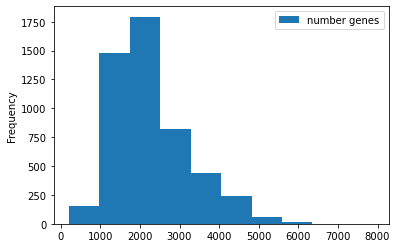

In [21]:
non_zero_cell_exp.plot.hist()

## 7.4 Histogram of the sum of all exponentiated values within each cell 

In [23]:
sum_counts = melted_liver_counts.groupby('cell_id').sum('expression')

In [184]:
sum_counts

,expression
cell_id,
AAACCCAAGCCGGAAT_TSP14_Liver_NA_10X_1_1,6.267566e+06
AAACCCAAGGTGCCTC_TSP14_Liver_NA_10X_1_1,3.614660e+06
AAACCCAAGTTGCTCA_TSP14_Liver_NA_10X_2_1,6.219432e+06
AAACCCACACTCCTGT_TSP6_Liver_NA_10X_1_1,5.092642e+05
AAACCCATCTCTGGTC_TSP6_Liver_NA_10X_1_2,8.644483e+05
...,...
TTTGTTGGTTGTTGCA_TSP6_Liver_NA_10X_1_1,1.666753e+06
TTTGTTGTCCAAATGC_TSP6_Liver_NA_10X_1_1,5.439909e+05
TTTGTTGTCCCGAGGT_TSP14_Liver_NA_10X_1_1,2.494263e+06


<AxesSubplot:ylabel='Frequency'>

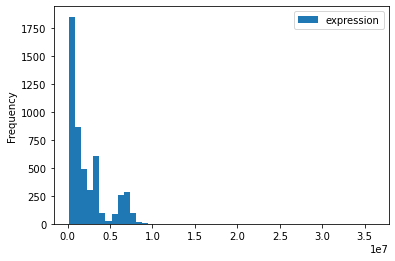

In [155]:
sum_counts.plot.hist(bins = 50)

**Zoom in on the values which fall below 1e+07**

<AxesSubplot:ylabel='Frequency'>

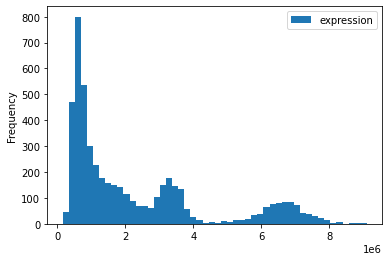

In [163]:
sum_counts[sum_counts.expression < 1e+07].plot.hist(bins = 50)

Since the consortium label their expression count axis as log(1 + CPM), where CPM is counts per million, I would expect our sum counts to add up to roughly one million however I see a range of values from 0.2-8 million for most cells. I also see that most of these cells fall within three distinct populations (sum counts roughly around 0.8 million, 3.2 million and 6.8 million). This is unexpected as I would expect a normal shaped distribution curve with the median lying around one million counts.

## 7.5 Expression of ACTB vs total expression
### 7.5.1 Scatterplot of ACTB expression vs total expression with cell_type colour legend

In [24]:
ACTB_counts = melted_liver_counts[melted_liver_counts.feature_name == 'ACTB']
ACTB_counts = ACTB_counts.set_axis(ACTB_counts.cell_id)
ACTB_counts = pd.DataFrame(ACTB_counts.expression)
ACTB_counts

,expression
cell_id,
AAACCCACACTCCTGT_TSP6_Liver_NA_10X_1_1,51.850670
AAACGAAGTACCAGAG_TSP6_Liver_NA_10X_1_1,21.424217
AAACGCTCAACGGCTC_TSP6_Liver_NA_10X_1_1,10.341937
AAAGAACAGCCTCTTC_TSP6_Liver_NA_10X_1_1,41.449539
AAAGAACGTAGCACAG_TSP6_Liver_NA_10X_1_1,71.307213
...,...
TTTGATCCATCGGCCA_TSP14_Liver_NA_10X_2_1,3.025066
TTTGGAGTCAGTCTTT_TSP14_Liver_NA_10X_2_1,3.062052
TTTGGTTGTCACTCGG_TSP14_Liver_NA_10X_2_1,10.507309


In [25]:
sum_counts.rename(columns = {'expression': 'sum_counts'}, inplace = True)

In [205]:
sum_counts

,sum_counts
cell_id,
AAACCCAAGCCGGAAT_TSP14_Liver_NA_10X_1_1,6.267566e+06
AAACCCAAGGTGCCTC_TSP14_Liver_NA_10X_1_1,3.614660e+06
AAACCCAAGTTGCTCA_TSP14_Liver_NA_10X_2_1,6.219432e+06
AAACCCACACTCCTGT_TSP6_Liver_NA_10X_1_1,5.092642e+05
AAACCCATCTCTGGTC_TSP6_Liver_NA_10X_1_2,8.644483e+05
...,...
TTTGTTGGTTGTTGCA_TSP6_Liver_NA_10X_1_1,1.666753e+06
TTTGTTGTCCAAATGC_TSP6_Liver_NA_10X_1_1,5.439909e+05
TTTGTTGTCCCGAGGT_TSP14_Liver_NA_10X_1_1,2.494263e+06


In [26]:
merged_ACTB_sum_counts_df = pd.merge(ACTB_counts, sum_counts, on = 'cell_id', how = 'outer')
merged_ACTB_sum_counts_df.rename(columns = {'expression': 'ACTB_counts'}, inplace = True)
merged_ACTB_sum_counts_df

,ACTB_counts,sum_counts
cell_id,,
AAACCCACACTCCTGT_TSP6_Liver_NA_10X_1_1,51.850670,5.092642e+05
AAACGAAGTACCAGAG_TSP6_Liver_NA_10X_1_1,21.424217,1.186145e+06
AAACGCTCAACGGCTC_TSP6_Liver_NA_10X_1_1,10.341937,2.259464e+06
AAAGAACAGCCTCTTC_TSP6_Liver_NA_10X_1_1,41.449539,5.751175e+05
AAAGAACGTAGCACAG_TSP6_Liver_NA_10X_1_1,71.307213,9.027531e+05
...,...,...
TTTGATCCATCGGCCA_TSP14_Liver_NA_10X_2_1,3.025066,3.515850e+06
TTTGGAGTCAGTCTTT_TSP14_Liver_NA_10X_2_1,3.062052,3.403235e+06
TTTGGTTGTCACTCGG_TSP14_Liver_NA_10X_2_1,10.507309,3.681179e+06


In [27]:
ACTB_cell_types = melted_liver_counts.set_axis(melted_liver_counts.cell_id)
ACTB_cell_types = ACTB_cell_types[ACTB_cell_types.feature_name == 'ACTB']
ACTB_cell_types = pd.DataFrame(ACTB_cell_types['cell_type'])

In [28]:
merged_df = pd.merge(merged_ACTB_sum_counts_df, ACTB_cell_types, on = 'cell_id', how = 'outer')
merged_df

,ACTB_counts,sum_counts,cell_type
cell_id,,,
AAACCCACACTCCTGT_TSP6_Liver_NA_10X_1_1,51.850670,5.092642e+05,macrophage
AAACGAAGTACCAGAG_TSP6_Liver_NA_10X_1_1,21.424217,1.186145e+06,monocyte
AAACGCTCAACGGCTC_TSP6_Liver_NA_10X_1_1,10.341937,2.259464e+06,endothelial cell of hepatic sinusoid
AAAGAACAGCCTCTTC_TSP6_Liver_NA_10X_1_1,41.449539,5.751175e+05,macrophage
AAAGAACGTAGCACAG_TSP6_Liver_NA_10X_1_1,71.307213,9.027531e+05,liver dendritic cell
...,...,...,...
TTTGATCCATCGGCCA_TSP14_Liver_NA_10X_2_1,3.025066,3.515850e+06,hepatocyte
TTTGGAGTCAGTCTTT_TSP14_Liver_NA_10X_2_1,3.062052,3.403235e+06,hepatocyte
TTTGGTTGTCACTCGG_TSP14_Liver_NA_10X_2_1,10.507309,3.681179e+06,endothelial cell of hepatic sinusoid


/home/jupyter/.local/lib/python3.10/site-packages/seaborn/_oldcore.py:1498: FutureWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, CategoricalDtype) instead
  if pd.api.types.is_categorical_dtype(vector):
/home/jupyter/.local/lib/python3.10/site-packages/seaborn/_oldcore.py:1498: FutureWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, CategoricalDtype) instead
  if pd.api.types.is_categorical_dtype(vector):
/home/jupyter/.local/lib/python3.10/site-packages/seaborn/_oldcore.py:1498: FutureWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, CategoricalDtype) instead
  if pd.api.types.is_categorical_dtype(vector):
/home/jupyter/.local/lib/python3.10/site-packages/seaborn/_oldcore.py:1498: FutureWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, CategoricalDtype) inst

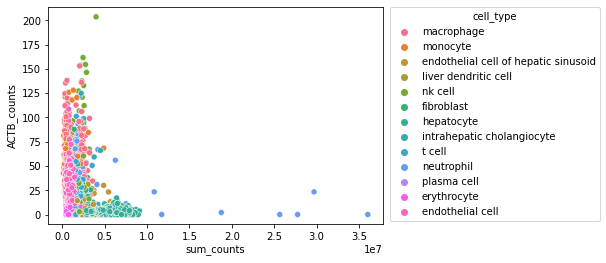

In [45]:
import seaborn as sns
import matplotlib.pyplot as plt

sns.scatterplot(data = merged_df, x = 'sum_counts', y = 'ACTB_counts', hue = 'cell_type')
plt.legend(bbox_to_anchor = (1.02, 1), loc = 'upper left', borderaxespad = 0, title = 'cell_type')

### 7.5.2 ACTB expression across all cells

In [28]:
ACTB_counts

,expression
cell_id,
AAACCCACACTCCTGT_TSP6_Liver_NA_10X_1_1,51.850670
AAACGAAGTACCAGAG_TSP6_Liver_NA_10X_1_1,21.424217
AAACGCTCAACGGCTC_TSP6_Liver_NA_10X_1_1,10.341937
AAAGAACAGCCTCTTC_TSP6_Liver_NA_10X_1_1,41.449539
AAAGAACGTAGCACAG_TSP6_Liver_NA_10X_1_1,71.307213
...,...
TTTGATCCATCGGCCA_TSP14_Liver_NA_10X_2_1,3.025066
TTTGGAGTCAGTCTTT_TSP14_Liver_NA_10X_2_1,3.062052
TTTGGTTGTCACTCGG_TSP14_Liver_NA_10X_2_1,10.507309


<AxesSubplot:ylabel='Frequency'>

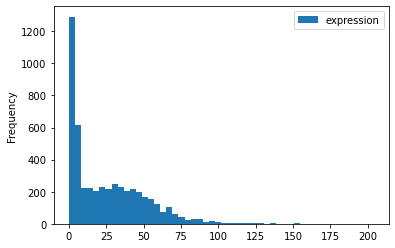

In [27]:
ACTB_counts.plot.hist(bins = 50)

# PySpark
# Liver Implementation

In [2]:
import pyspark
from pyspark.conf import SparkConf
from pyspark.sql import SparkSession
from pyspark.sql.functions import arrays_zip, explode, map_keys, col
import pyspark.sql.functions as f
from pyspark.sql.types import FloatType

In [3]:
# Initialise Spark session
sparkConf = (
    SparkConf()
    .set('spark.driver.memory', '60g')
    .set('spark.executor.memory', '60g')
    .set('spark.driver.maxResultSize', '0')
    .set('spark.debug.maxToStringFields', '2000')
    .set('spark.sql.execution.arrow.maxRecordsPerBatch', '500000')
)
spark = SparkSession.builder.config(conf=sparkConf).master('local[*]').getOrCreate()

Setting default log level to "

# 1. Import data into Pyspark
## 1.1 Download data and read in data in .h5ad format

In [14]:
liver = sc.read_h5ad('tabula_sapiens_liver.h5ad')

In [3]:
liver

AnnData object with n_obs × n_vars = 5007 × 58604
    obs: 'assay_ontology_term_id', 'donor_id', 'anatomical_information', 'n_counts_UMIs', 'n_genes', 'cell_ontology_class', 'free_annotation', 'manually_annotated', 'compartment', 'sex_ontology_term_id', 'disease_ontology_term_id', 'is_primary_data', 'organism_ontology_term_id', 'suspension_type', 'cell_type_ontology_term_id', 'tissue_ontology_term_id', 'development_stage_ontology_term_id', 'self_reported_ethnicity_ontology_term_id', 'cell_type', 'assay', 'disease', 'organism', 'sex', 'tissue', 'self_reported_ethnicity', 'development_stage'
    var: 'feature_type', 'highly_variable', 'means', 'dispersions', 'dispersions_norm', 'mean', 'std', 'ensembl_version', 'feature_is_filtered', 'feature_name', 'feature_reference', 'feature_biotype'
    uns: '_scvi', '_training_mode', 'assay_colors', 'cell_ontology_class_colors', 'dendrogram_cell_type_tissue', 'dendrogram_computational_compartment_assignment', 'dendrogram_consensus_prediction', 'den

## 1.2 Convert anndata object to csv file for import into pyspark (slow)

In [6]:
#convert anndata object to csv file in order to read it into pyspark
liver.write_csvs('/home/jupyter/liver.csv', skip_data = False)

/home/jupyter/.local/lib/python3.10/site-packages/anndata/_core/aligned_mapping.py:232: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  df[f"{key}{icolumn + 1}"] = column
/home/jupyter/.local/lib/python3.10/site-packages/anndata/_core/aligned_mapping.py:232: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  df[f"{key}{icolumn + 1}"] = column
/home/jupyter/.local/lib/python3.10/site-packages/anndata/_core/aligned_mapping.py:232: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` ma

Technically we only need the .X, .obs and .var dataframes so we could write these as individual csv files as such to eliminate the runtime.

## 1.3 Read csv files into pyspark

Running `spark.read.option("header", True).csv('liver/X.csv')` threw an error because I think the csv file was either too large or the columns had no names as they were not saved as indexes.

In [21]:
liver_obs = spark.read.option("header", True).csv('liver/obs.csv')
liver_obs

DataFrame[cell_id: string, assay_ontology_term_id: string, donor_id: string, anatomical_information: string, n_counts_UMIs: string, n_genes: string, cell_ontology_class: string, free_annotation: string, manually_annotated: string, compartment: string, sex_ontology_term_id: string, disease_ontology_term_id: string, is_primary_data: string, organism_ontology_term_id: string, suspension_type: string, cell_type_ontology_term_id: string, tissue_ontology_term_id: string, development_stage_ontology_term_id: string, self_reported_ethnicity_ontology_term_id: string, cell_type: string, assay: string, disease: string, organism: string, sex: string, tissue: string, self_reported_ethnicity: string, development_stage: string]

In [22]:
liver_var = spark.read.option("header", True).csv('liver/var.csv')
liver_var

DataFrame[ensemblid: string, feature_type: string, highly_variable: string, means: string, dispersions: string, dispersions_norm: string, mean: string, std: string, ensembl_version: string, feature_is_filtered: string, feature_name: string, feature_reference: string, feature_biotype: string]

## 1.5 Create cell x gene count matrix

In [15]:
#convert count sparse matrix into pandas dataframe
liver_X_df = pd.DataFrame.sparse.from_spmatrix(liver.X)

liver_X_df

,0,1,2,3,4,5,6,7,8,9,...,58594,58595,58596,58597,58598,58599,58600,58601,58602,58603
0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,4.514050,0.000000,0.000000,0.0,3.066113,1.735281,0.000000,4.651200,0.0,0.000000
1,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,4.493524,0.000000,0.000000,0.0,3.011087,0.000000,0.000000,4.890568,0.0,0.000000
2,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,4.611789,0.000000,0.000000,0.0,3.832069,1.114132,0.000000,4.693941,0.0,0.000000
3,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,4.344065,0.000000,0.000000,0.0,2.975372,0.000000,0.000000,4.572667,0.0,0.000000
4,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,4.443695,0.000000,0.000000,0.0,3.143889,0.000000,0.000000,4.533354,0.0,0.000000
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
5002,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,4.577865,1.506503,0.792537,0.0,3.344307,1.543429,0.883882,4.122873,0.0,2.078453
5003,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,4.099157,0.000000,1.211337,0.0,2.707354,0.939532,4.610079,3.635269,0.0,1.836136
5004,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,1.390459,0.000000,0.000000,0.0,0.000000,0.000000,0.000000,1.973971,0.0,0.000000
5005,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,1.335147,0.000000,0.000000,0.0,1.490789,0.000000,0.000000,2.239632,0.0,0.000000


In [4]:
#add ensemblid to genes
ensemblid = liver.var.index.values
liver_X_df = liver_X_df.set_axis(ensemblid, axis = 1)

**This step could have been done using the feature_names as done above however for clarity ensemblid has been used**

In [5]:
#add cell_id and cell_type
cell_id = liver.obs.index.values
cell_type = liver.obs['cell_type'].values.to_list()
liver_X_df.insert(0, 'cell_id', cell_id)
liver_X_df.insert(1, 'cell_type', cell_type)

/tmp/ipykernel_4524/3819472889.py:3: FutureWarning: Categorical.to_list is deprecated and will be removed in a future version. Use obj.tolist() instead
  cell_type = liver.obs['cell_type'].values.to_list()


In [7]:
liver_X_df

,cell_id,cell_type,ENSG00000223972,ENSG00000227232,ENSG00000278267,ENSG00000243485,ENSG00000284332,ENSG00000237613,ENSG00000268020,ENSG00000240361,...,ENSG00000198886,ENSG00000210176,ENSG00000210184,ENSG00000210191,ENSG00000198786,ENSG00000198695,ENSG00000210194,ENSG00000198727,ENSG00000210195,ENSG00000210196
0,AAACCCACACTCCTGT_TSP6_Liver_NA_10X_1_1,macrophage,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,4.514050,0.000000,0.000000,0.0,3.066113,1.735281,0.000000,4.651200,0.0,0.000000
1,AAACGAAGTACCAGAG_TSP6_Liver_NA_10X_1_1,monocyte,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,4.493524,0.000000,0.000000,0.0,3.011087,0.000000,0.000000,4.890568,0.0,0.000000
2,AAACGCTCAACGGCTC_TSP6_Liver_NA_10X_1_1,endothelial cell of hepatic sinusoid,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,4.611789,0.000000,0.000000,0.0,3.832069,1.114132,0.000000,4.693941,0.0,0.000000
3,AAAGAACAGCCTCTTC_TSP6_Liver_NA_10X_1_1,macrophage,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,4.344065,0.000000,0.000000,0.0,2.975372,0.000000,0.000000,4.572667,0.0,0.000000
4,AAAGAACGTAGCACAG_TSP6_Liver_NA_10X_1_1,liver dendritic cell,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,4.443695,0.000000,0.000000,0.0,3.143889,0.000000,0.000000,4.533354,0.0,0.000000
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
5002,TTTGATCCATCGGCCA_TSP14_Liver_NA_10X_2_1,hepatocyte,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,4.577865,1.506503,0.792537,0.0,3.344307,1.543429,0.883882,4.122873,0.0,2.078453
5003,TTTGGAGTCAGTCTTT_TSP14_Liver_NA_10X_2_1,hepatocyte,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,4.099157,0.000000,1.211337,0.0,2.707354,0.939532,4.610079,3.635269,0.0,1.836136
5004,TTTGGTTGTCACTCGG_TSP14_Liver_NA_10X_2_1,endothelial cell of hepatic sinusoid,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,1.390459,0.000000,0.000000,0.0,0.000000,0.000000,0.000000,1.973971,0.0,0.000000
5005,TTTGTTGAGGACTGGT_TSP14_Liver_NA_10X_2_1,mature NK T cell,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,1.335147,0.000000,0.000000,0.0,1.490789,0.000000,0.000000,2.239632,0.0,0.000000


## 1.6 Reformat dataframe in long format for implementation in pyspark

In [21]:
cols = liver_X_df.columns[2:]

melted_liver_X_df = pd.melt(liver_X_df, id_vars = ['cell_id', 'cell_type'], 
                            value_vars = cols, 
                           var_name = 'ensemblid', 
                           value_name = 'expression')

In [22]:
melted_liver_X_df

,cell_id,cell_type,ensemblid,expression
0,AAACCCACACTCCTGT_TSP6_Liver_NA_10X_1_1,macrophage,ENSG00000223972,0.000000
1,AAACGAAGTACCAGAG_TSP6_Liver_NA_10X_1_1,monocyte,ENSG00000223972,0.000000
2,AAACGCTCAACGGCTC_TSP6_Liver_NA_10X_1_1,endothelial cell of hepatic sinusoid,ENSG00000223972,0.000000
3,AAAGAACAGCCTCTTC_TSP6_Liver_NA_10X_1_1,macrophage,ENSG00000223972,0.000000
4,AAAGAACGTAGCACAG_TSP6_Liver_NA_10X_1_1,liver dendritic cell,ENSG00000223972,0.000000
...,...,...,...,...
293430223,TTTGATCCATCGGCCA_TSP14_Liver_NA_10X_2_1,hepatocyte,ENSG00000210196,2.078453
293430224,TTTGGAGTCAGTCTTT_TSP14_Liver_NA_10X_2_1,hepatocyte,ENSG00000210196,1.836136
293430225,TTTGGTTGTCACTCGG_TSP14_Liver_NA_10X_2_1,endothelial cell of hepatic sinusoid,ENSG00000210196,0.000000
293430226,TTTGTTGAGGACTGGT_TSP14_Liver_NA_10X_2_1,mature NK T cell,ENSG00000210196,0.000000


This data frame has 293 million rows and this is for a dataset with only 5007 cells and 58,606 genes.

## 1.7 Change sparse expression column to dense

Need to do this in order for the data to be saved and read as a parquet file.

In [23]:
melted_liver_X_df.dtypes

cell_id                   object
cell_type                 object
ensemblid                 object
expression    Sparse[float32, 0]
dtype: object

In [24]:
melted_liver_X_df.expression = melted_liver_X_df.expression.values.to_dense()

In [25]:
melted_liver_X_df.dtypes

cell_id        object
cell_type      object
ensemblid      object
expression    float32
dtype: object

## 1.8 Saving melted df as a parquet file and reading into pyspark

In [26]:
melted_liver_X_df.to_parquet('liver/melted_liver_X_df.parquet')

In [12]:
liver_X = spark.read.parquet('liver/melted_liver_X_df.parquet')

# 2. Querying Data
## 2.1 Visualise liver_X schema

In [5]:
liver_X.printSchema()

root
 |-- cell_id: string (nullable = true)
 |-- cell_type: string (nullable = true)
 |-- ensemblid: string (nullable = true)
 |-- expression: float (nullable = true)



In [6]:
liver_X.show()

+--------------------+--------------------+---------------+----------+
|             cell_id|           cell_type|      ensemblid|expression|
+--------------------+--------------------+---------------+----------+
|AAACCCACACTCCTGT_...|          macrophage|ENSG00000223972|       0.0|
|AAACGAAGTACCAGAG_...|            monocyte|ENSG00000223972|       0.0|
|AAACGCTCAACGGCTC_...|endothelial cell ...|ENSG00000223972|       0.0|
|AAAGAACAGCCTCTTC_...|          macrophage|ENSG00000223972|       0.0|
|AAAGAACGTAGCACAG_...|liver dendritic cell|ENSG00000223972|       0.0|
|AAAGAACGTTTCTTAC_...|          macrophage|ENSG00000223972|       0.0|
|AAAGAACTCCTTATGT_...|    mature NK T cell|ENSG00000223972|       0.0|
|AAAGAACTCTTCTCAA_...|          macrophage|ENSG00000223972|       0.0|
|AAAGGATAGTCGAAAT_...|            monocyte|ENSG00000223972|       0.0|
|AAAGGATCAAATCAGA_...|endothelial cell ...|ENSG00000223972|       0.0|
|AAAGGATCACATGAAA_...|          macrophage|ENSG00000223972|       0.0|
|AAAGG

## 2.2 Calculate median gene expression in each cell type
### 2.2.1 Define find_median function

In [24]:
#function taken from https://www.educba.com/pyspark-median/
def find_median(values_list):
    try:
        median = np.median(values_list)
        return float(median)
    except Exception:
        return None

In [25]:
#register user-defined function (UDF) and data type needed for this
med_find = f.udf(find_median, FloatType())

### 2.2.2 Apply find_median UDF to grouped data

In [9]:
agg_liver_X = (
    liver_X
    .groupby('cell_type', 'ensemblid')
    .agg(
        f.collect_list('expression')
        .alias('expression'))
    .withColumn('median_expression', med_find('expression'))
    )

In [10]:
agg_liver_X.show()

+---------+---------------+--------------------+-----------------+
|cell_type|      ensemblid|          expression|median_expression|
+---------+---------------+--------------------+-----------------+
|   T cell|ENSG00000001561|[0.0, 0.0, 0.0, 0...|              0.0|
|   T cell|ENSG00000002745|[0.0, 0.0, 0.0, 0...|              0.0|
|   T cell|ENSG00000003096|[0.0, 0.0, 0.0, 0...|              0.0|
|   T cell|ENSG00000003147|[0.0, 0.0, 0.0, 0...|              0.0|
|   T cell|ENSG00000004455|[0.0, 0.0, 0.0, 0...|              0.0|
|   T cell|ENSG00000005102|[0.0, 0.0, 0.0, 0...|              0.0|
|   T cell|ENSG00000005175|[0.0, 0.0, 0.0, 0...|              0.0|
|   T cell|ENSG00000005379|[0.0, 0.0, 0.0, 0...|              0.0|
|   T cell|ENSG00000005471|[0.0, 0.0, 0.0, 0...|              0.0|
|   T cell|ENSG00000006210|[0.0, 0.0, 0.0, 0...|              0.0|
|   T cell|ENSG00000006555|[0.0, 0.0, 0.0, 0...|              0.0|
|   T cell|ENSG00000006659|[0.0, 0.0, 0.0, 0...|              

# All Cells

In [19]:
import pyspark
from pyspark.conf import SparkConf
from pyspark.sql import SparkSession
from pyspark.sql.functions import arrays_zip, explode, map_keys, col
import pyspark.sql.functions as f
from pyspark.sql.types import FloatType

In [20]:
# Initialise Spark session
sparkConf = (
    SparkConf()
    .set('spark.driver.memory', '60g')
    .set('spark.executor.memory', '60g')
    .set('spark.driver.maxResultSize', '0')
    .set('spark.debug.maxToStringFields', '2000')
    .set('spark.sql.execution.arrow.maxRecordsPerBatch', '500000')
)
spark = SparkSession.builder.config(conf=sparkConf).master('local[*]').getOrCreate()

# 1. Import data into PySpark
## 1.1 Download data and read in .h5ad format

In [5]:
all_cells = sc.read_h5ad('tabula_sapiens_all_cells.h5ad')

In [5]:
all_cells

AnnData object with n_obs × n_vars = 483152 × 58604
    obs: 'tissue_in_publication', 'assay_ontology_term_id', 'donor_id', 'anatomical_information', 'n_counts_UMIs', 'n_genes', 'cell_ontology_class', 'free_annotation', 'manually_annotated', 'compartment', 'sex_ontology_term_id', 'disease_ontology_term_id', 'is_primary_data', 'organism_ontology_term_id', 'suspension_type', 'cell_type_ontology_term_id', 'tissue_ontology_term_id', 'development_stage_ontology_term_id', 'self_reported_ethnicity_ontology_term_id', 'cell_type', 'assay', 'disease', 'organism', 'sex', 'tissue', 'self_reported_ethnicity', 'development_stage'
    var: 'feature_type', 'highly_variable', 'means', 'dispersions', 'dispersions_norm', 'mean', 'std', 'feature_is_filtered', 'feature_name', 'feature_reference', 'feature_biotype'
    uns: '_scvi', '_training_mode', 'dendrogram_cell_type_tissue', 'dendrogram_computational_compartment_assignment', 'dendrogram_consensus_prediction', 'dendrogram_tissue_cell_type', 'donor_id_c

## 1.2 Create cell x gene count matrix as dataframe

In [6]:
#convert count sparse matrix to pandas dataframe
all_cells_X_df = pd.DataFrame.sparse.from_spmatrix(all_cells.X)

In [7]:
#add ensemblid to genes
ensemblid = all_cells.var.index.values
all_cells_X_df = all_cells_X_df.set_axis(ensemblid, axis = 1)

In [8]:
#add cell_id and cell_type as columns
cell_id = all_cells.obs.index.values
cell_type = all_cells.obs['cell_type'].values.to_list()
all_cells_X_df.insert(0, 'cell_id', cell_id)
all_cells_X_df.insert(1, 'cell_type', cell_type)

/tmp/ipykernel_2390/1594358502.py:3: FutureWarning: Categorical.to_list is deprecated and will be removed in a future version. Use obj.tolist() instead
  cell_type = all_cells.obs['cell_type'].values.to_list()


In [9]:
all_cells_X_df

,cell_id,cell_type,ENSG00000223972,ENSG00000227232,ENSG00000278267,ENSG00000243485,ENSG00000284332,ENSG00000237613,ENSG00000268020,ENSG00000240361,...,ENSG00000198886,ENSG00000210176,ENSG00000210184,ENSG00000210191,ENSG00000198786,ENSG00000198695,ENSG00000210194,ENSG00000198727,ENSG00000210195,ENSG00000210196
0,AAACCCACACTCCTGT_TSP6_Liver_NA_10X_1_1,macrophage,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,4.514050,0.0,0.0,0.0,3.066113,1.735281,0.0,4.651200,0.0,0.000000
1,AAACGAAGTACCAGAG_TSP6_Liver_NA_10X_1_1,monocyte,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,4.493524,0.0,0.0,0.0,3.011087,0.000000,0.0,4.890568,0.0,0.000000
2,AAACGCTCAACGGCTC_TSP6_Liver_NA_10X_1_1,endothelial cell of hepatic sinusoid,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,4.611789,0.0,0.0,0.0,3.832069,1.114132,0.0,4.693941,0.0,0.000000
3,AAAGAACAGCCTCTTC_TSP6_Liver_NA_10X_1_1,macrophage,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,4.344065,0.0,0.0,0.0,2.975372,0.000000,0.0,4.572667,0.0,0.000000
4,AAAGAACGTAGCACAG_TSP6_Liver_NA_10X_1_1,liver dendritic cell,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,4.443695,0.0,0.0,0.0,3.143889,0.000000,0.0,4.533354,0.0,0.000000
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
483147,TSP2_Vasculature_aorta_SS2_B114577_B133059_End...,endothelial cell,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,3.455786,0.0,0.0,0.0,2.986555,0.760420,0.0,2.158757,0.0,0.000000
483148,TSP2_Vasculature_aorta_SS2_B114577_B133059_End...,endothelial cell,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,4.292184,0.0,0.0,0.0,3.560022,2.219024,0.0,3.486868,0.0,0.000000
483149,TSP2_Vasculature_aorta_SS2_B114577_B133059_End...,endothelial cell,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,3.031555,0.0,0.0,0.0,4.286012,2.549905,0.0,3.976863,0.0,5.355007
483150,TSP2_Vasculature_aorta_SS2_B114577_B133059_End...,endothelial cell,0.0,10.0,0.0,0.0,0.0,0.0,0.0,0.0,...,2.405994,0.0,0.0,0.0,4.814424,4.026218,0.0,3.945915,0.0,0.000000


## 1.3 Reformat dataframe from wide to long format

**Unable to do this step with all cells as it is too large for the python kernel to process**

In [ ]:
cols = all_cells_X_df.columns[2:]
melted_all_cells_X_df = pd.melt(all_cells_X_df, 
                                id_vars = ['cell_id', 'cell_type'], 
                               value_vars = cols, 
                               var_name = 'ensemblid', 
                               value_name = 'expression')

# Verifying Pandas Median Data with PySpark Median Data

In [14]:
liver = sc.read_h5ad('tabula_sapiens_liver.h5ad')
liver_X_df = pd.DataFrame.sparse.from_spmatrix(liver.X)

gene_name = liver.var['feature_name'].values.to_list()
liver_X_df = liver_X_df.set_axis(gene_name, axis = 1)

cell_id = liver.obs.index.values
cell_type = liver.obs['cell_type'].values.to_list()
liver_X_df.insert(0, 'cell_id', cell_id)
liver_X_df.insert(1, 'cell_type', cell_type)

/tmp/ipykernel_13744/4132586194.py:4: FutureWarning: Categorical.to_list is deprecated and will be removed in a future version. Use obj.tolist() instead
  gene_name = liver.var['feature_name'].values.to_list()
/tmp/ipykernel_13744/4132586194.py:8: FutureWarning: Categorical.to_list is deprecated and will be removed in a future version. Use obj.tolist() instead
  cell_type = liver.obs['cell_type'].values.to_list()


In [15]:
cols = liver_X_df.columns[2:]

melted_liver_X_df = pd.melt(liver_X_df, id_vars = ['cell_id', 'cell_type'], 
                            value_vars = cols, 
                           var_name = 'gene_name', 
                           value_name = 'expression')

In [16]:
melted_liver_X_df.expression = melted_liver_X_df.expression.values.to_dense()

In [17]:
median_liver_X = melted_liver_X_df.groupby(['cell_type', 'gene_name']).median('expression')

median_liver_X

expression
cell_type   gene_name                          
T cell      5S_rRNA_ENSG00000276861         0.0
            5S_rRNA_ENSG00000277411         0.0
            5S_rRNA_ENSG00000277488         0.0
            5S_rRNA_ENSG00000285609         0.0
            5S_rRNA_ENSG00000285626         0.0
...                                         ...
plasma cell bP-2189O9.5                     0.0
            hsa-mir-1253                    0.0
            hsa-mir-423                     0.0
            snoZ196                         0.0
            yR211F11.2                      0.0

[761852 rows x 1 columns]

In [45]:
#genes with a non-zero median expression using pandas dataframe
median_liver_X[(median_liver_X.expression != 0)]

expression
cell_type   gene_name            
T cell      AAK1         2.227230
            ACAP1        1.745173
            ACTB         2.743471
            ACTG1        2.151516
            ACTR2        1.604836
...                           ...
plasma cell ZNF207       0.932977
            ZNF292       0.349221
            ZNF706       1.314754
            ZNHIT1       1.012897
            ZRANB2       1.448085

[12450 rows x 1 columns]

*Out of 761,852 median scores only 12,450 are non-zero.*

In [18]:
melted_liver_X_df.to_parquet('liver/gene_name_liver_X_df.parquet')

In [21]:
liver_X = spark.read.parquet('liver/gene_name_liver_X_df.parquet')

In [ ]:
#function taken from https://www.educba.com/pyspark-median/
def find_median(values_list):
    try:
        median = np.median(values_list)
        return float(median)
    except Exception:
        return None

In [ ]:
#register user-defined function (UDF) and data type needed for this
med_find = f.udf(find_median, FloatType())

In [26]:
agg_gene_name_liver_X = (
    liver_X
    .groupby('cell_type', 'gene_name')
    .agg(
        f.collect_list('expression')
        .alias('expression'))
    .withColumn('median_expression', med_find('expression'))
    )

In [27]:
agg_gene_name_liver_X.show()

+---------+--------------------+--------------------+-----------------+
|cell_type|           gene_name|          expression|median_expression|
+---------+--------------------+--------------------+-----------------+
|   T cell|5_8S_rRNA_ENSG000...|[0.0, 0.0, 0.0, 0...|              0.0|
|   T cell|             A2M-AS1|[0.0, 0.0, 0.0, 0...|              0.0|
|   T cell|               A2ML1|[0.0, 0.0, 0.0, 0...|              0.0|
|   T cell|           A2ML1-AS1|[0.0, 0.0, 0.0, 0...|              0.0|
|   T cell|               A4GNT|[0.0, 0.0, 0.0, 0...|              0.0|
|   T cell|             AADACL2|[0.0, 0.0, 0.0, 0...|              0.0|
|   T cell|             AADACL3|[0.0, 0.0, 0.0, 0...|              0.0|
|   T cell|                AARD|[0.0, 0.0, 0.0, 0...|              0.0|
|   T cell|            AASDHPPT|[0.0, 3.559449, 0...|              0.0|
|   T cell|                AASS|[0.0, 0.0, 0.0, 0...|              0.0|
|   T cell| ABC10-44372100G24.1|[0.0, 0.0, 0.0, 0...|           

In [49]:
#check median expression for gene ACTG1 in T cell and ZNF706 in plasma cell
agg_gene_name_liver_X.createOrReplaceTempView("TAB")
spark.sql("SELECT * FROM TAB WHERE " + "gene_name IN ('ACTG1', 'ZNF706')").show()

+--------------------+---------+--------------------+-----------------+
|           cell_type|gene_name|          expression|median_expression|
+--------------------+---------+--------------------+-----------------+
|         erythrocyte|   ZNF706|[0.0, 0.0, 0.0, 0...|              0.0|
|          macrophage|   ZNF706|[0.0, 2.5432155, ...|        1.1194693|
|            monocyte|   ZNF706|[0.0, 1.798161, 2...|        1.3397723|
|          fibroblast|   ZNF706|[1.0836954, 0.0, ...|       0.79891676|
|    endothelial cell|   ZNF706|[0.0, 1.2491742, ...|        1.2388797|
|liver dendritic cell|   ZNF706|[1.4844936, 0.0, ...|        1.4015207|
|         plasma cell|   ZNF706|[3.2332926, 2.882...|        1.3147542|
|          neutrophil|   ZNF706|[0.0, 0.0, 0.0, 0...|              0.0|
|intrahepatic chol...|   ZNF706|[3.1335206, 0.0, ...|        1.6856848|
|    mature NK T cell|   ZNF706|[0.0, 2.955844, 1...|              0.0|
|endothelial cell ...|   ZNF706|[2.5447338, 1.233...|           

The ACTG1 gene within the T cell cell_type has a median expression of 2.151516 when using the pandas.df.median() function and here we see with the pyspark implementation the median is 2.1515164 which is the same just with one extra decimal place. Similarly with ZNF706 the plasma cell in the pandas df has 1.314754 whilst pyspark is the same with an extra decimal place 1.3147542.

Actin beta (ACTB), its Ensembl ID is ENSG00000075624. It is a housekeeping gene and should be broadly expressed. So for all cell types, we definitely expect to see a non-zero median value

In [52]:
spark.sql("SELECT * FROM TAB WHERE " + "gene_name IN ('ACTB')").show()

+--------------------+---------+--------------------+-----------------+
|           cell_type|gene_name|          expression|median_expression|
+--------------------+---------+--------------------+-----------------+
|    endothelial cell|     ACTB|[2.321531, 3.5809...|        3.3048465|
|              T cell|     ACTB|[3.4181693, 3.085...|        2.7434707|
|          fibroblast|     ACTB|[3.5878563, 3.483...|        3.2087526|
|          neutrophil|     ACTB|[3.5005133, 2.190...|        2.9636347|
|intrahepatic chol...|     ACTB|[2.3553882, 3.768...|         1.904201|
|    mature NK T cell|     ACTB|[3.9262035, 2.924...|         3.639651|
|            monocyte|     ACTB|[3.1101415, 4.317...|        3.9090247|
|          macrophage|     ACTB|[3.9674704, 3.748...|        3.6997802|
|          hepatocyte|     ACTB|[1.1648109, 0.588...|        1.3579696|
|         plasma cell|     ACTB|[3.7846367, 3.829...|        1.8998551|
|         erythrocyte|     ACTB|[0.965919, 3.9693...|        1.5

In [53]:
spark.sql("SELECT * FROM TAB WHERE " + "gene_name IN ('HLA-A')").show()

+--------------------+---------+--------------------+-----------------+
|           cell_type|gene_name|          expression|median_expression|
+--------------------+---------+--------------------+-----------------+
|endothelial cell ...|    HLA-A|[0.7712685, 2.358...|         1.911698|
|    mature NK T cell|    HLA-A|[2.5888026, 2.128...|        1.9880068|
|          hepatocyte|    HLA-A|[0.0, 0.63337713,...|              0.0|
|         erythrocyte|    HLA-A|[0.0, 0.11222476,...|              0.0|
|              T cell|    HLA-A|[1.245452, 2.1019...|        2.3811917|
|    endothelial cell|    HLA-A|[2.948263, 1.7976...|        2.3297784|
|liver dendritic cell|    HLA-A|[1.8237816, 1.574...|        1.4934633|
|          neutrophil|    HLA-A|[0.0, 1.4698974, ...|              0.0|
|          macrophage|    HLA-A|[2.379818, 2.3616...|        1.8383048|
|         plasma cell|    HLA-A|[2.056801, 0.9138...|        1.2146106|
|          fibroblast|    HLA-A|[0.0, 0.0, 2.0686...|        1.0

# ACTB Normalised Expression in Hepatocytes

## Scaled

In [59]:
#obtain ACTB data for hepatocytes
ACTB_hepatocytes_scaled = liver_X_df[liver_X_df['cell_type'] == 'hepatocyte']['ACTB']

ACTB_hepatocytes_scaled

26      1.164811
85      0.588775
114     0.000000
159     0.000000
203     0.932045
          ...   
5000    1.611552
5001    1.704657
5002    1.392541
5003    1.401688
5006    0.000000
Name: ACTB, Length: 1558, dtype: Sparse[float64, 0]

<AxesSubplot:ylabel='Frequency'>

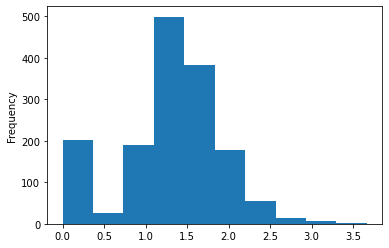

In [60]:
ACTB_hepatocytes_scaled.plot.hist()